In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
seed = 42
np.random.seed(seed)
import matplotlib.pyplot as plt
import matplotlib
from IPython.display import display_pretty, display_html
import python_utils.python_utils.basic as basic
import pandas as pd
import pdb
import itertools
import functools
import scipy.stats
import scipy
import cvxopt
import autograd
import autograd.numpy as np
import domain_adapt.domain_adapt.new.fxns as fxns
import domain_adapt.domain_adapt.new.utils as utils
import domain_adapt.domain_adapt.new.optimizers as optimizers
import domain_adapt.domain_adapt.SDR_data as data

Couldn't import dot_parser, loading of dot files will not be possible.


In [3]:
# test weighted_squared_loss gradient

np.random.seed(42)

random_data = data.random_data(x_dim=2, shift=1.)
num_train, num_test = 15, 20
xs_train, xs_test, ys_train, ys_test = random_data.sample(num_train=num_train, num_test=num_test)

u_dim = 1
B = np.array([1.,2.]) # 1d, not 2d
#B = utils.ortho(np.array([[1.,2.]]).T)
ws = np.random.uniform(size=num_train)

#tradeoff = 10.
#tradeoff = .01
tradeoff = .005



weighted_lsqr_loss_fxn = fxns.two_step( # B, xs_train, xs_test, ys_train, sigma, b_logreg, c_B
    g=fxns.fxn.autograd_fxn(_val=fxns.b_to_logreg_ratios_scale_sigma), # b_logreg, xs_train, xs_test, sigma, B
#   g=fxns.fxn.autograd_fxn(_val=fxns.b_to_logreg_ratios),
    h=fxns.sum( # B, xs_train, ys_train, c_B, ws_train
        fs=[
            fxns.fxn.autograd_fxn(_val=fxns.weighted_squared_loss_given_B), # B, xs_train, ys_train, c_B, ws_train
            fxns.fxn.autograd_fxn(_val=fxns.weight_reg), # ws_train
            ],
        fs_argnums=[
            (0,1,2,3,4),
            (4,)
        ],
        weights=[
            1.,
            tradeoff,
        ],
        ),
    g_argnums=(5,1,2,4,0),
    h_argnums=(0,1,3,6),
    g_val_h_argnum=4,
)
b_logreg = np.random.normal(size=num_train+num_test)
sigma = np.array([.5])
c_B = 0.1
weighted_lsqr_loss_fxn.grad_check(B, xs_train, xs_test, ys_train, sigma, b_logreg, c_B, care_argnums=(0,))

5.0 max pre
2.16572223666 max post
Autograd FloatNode with value 5.0 and 1 tape(s) max pre
Autograd FloatNode with value 2.16572223666 and 1 tape(s) max post
5.0 max pre
2.16190272235 max post
5.0 max pre
2.16800638333 max post
anal_grad (2,)
[-83.10629342  65.05006607]
numerical_grad (2,)
[-82.69594478  65.12613905]
error 0.417340506353


In [4]:
# test logreg ratio gradient, naive

np.random.seed(42)

# get data
random_data = data.random_data(x_dim=2, shift=1.)
num_train, num_test = 15, 20
xs_train, xs_test, ys_train, ys_test = random_data.sample(num_train=num_train, num_test=num_test)

# 
#w_max = 10
#eps = 0.001
logreg_ratio_objective = fxns.logreg_ratio_objective.autograd_fxn(scale_sigma=True)
dlogreg_ratio_objective_db = fxns.dopt_objective_dx.autograd_fxn(logreg_ratio_objective)
damp = .1
def lstsq_solver(A,b): 
    ans = scipy.sparse.linalg.lsmr(A, b, damp=damp)
    print ans, 'end'
    return ans[0]
#lstsq_solver = lambda A,b: scipy.sparse.linalg.lsmr(A, b, damp=damp)[0]
cg_solver = lambda A,b: scipy.sparse.linalg.cg(A, b)[0]
lsmr_solver = None
lin_solver = cg_solver
b_opt_given_B_fxn = fxns.cvx_opt( # xs_train, xs_test, sigma, B, c_logreg
    lin_solver=lin_solver, 
    objective=logreg_ratio_objective, 
    dobjective_dx=dlogreg_ratio_objective_db
)
sigma = np.array([.5])
print sigma
B = np.array([1.,2.])
c_logreg = 0.1
b_opt = b_opt_given_B_fxn.val(xs_train, xs_test, sigma, B, c_logreg)
b_opt_given_B_fxn.grad_check(xs_train, xs_test, sigma, B, c_logreg, care_argnums=(3,))

[ 0.5]
num_tight: 0
solver error: 2.24786619167e-05
num_tight: 0
solver error: 1.01003889922e-05
anal_grad (35, 2)
[[ -7.82694344e+00   2.70842879e+00]
 [ -1.89220567e+00  -3.56211458e-01]
 [  1.15041432e+00  -6.47755596e-01]
 [  1.43842480e+00  -1.20106979e+00]
 [ -4.37481821e+00   2.09199209e+00]
 [  6.77125049e-01  -2.76573175e-01]
 [ -4.69867127e-01   1.83971731e-01]
 [ -4.13128718e-01   1.95259815e-01]
 [ -3.05152534e+00   1.10152998e+00]
 [ -4.26479164e-01   1.35356795e-01]
 [ -3.84266875e+00   9.38603926e-01]
 [ -3.39845632e-01   1.40230096e-01]
 [ -4.91382818e+00   1.95192818e+00]
 [ -1.92020205e+00   6.33396809e-01]
 [ -1.60741257e+00   5.16331428e-01]
 [ -1.00562779e+00   4.68836134e-01]
 [  5.33644639e+00  -1.47092650e+00]
 [ -5.95399475e-01   8.45080496e-01]
 [  9.26049463e-01  -6.28836451e-01]
 [ -6.29380410e-01   3.36507552e-01]
 [  1.71421072e+00  -2.14899167e-01]
 [  1.52823708e-01   5.03672949e-03]
 [  5.68192848e+00  -2.17136161e+00]
 [  5.92918708e-01  -1.51779230e-0

In [5]:
# test g_thru_xopt gradient

np.random.seed(42)

# get data
random_data = data.random_data(x_dim=2, shift=1.)
num_train, num_test = 15, 20
xs_train, xs_test, ys_train, ys_test = random_data.sample(num_train=num_train, num_test=num_test)

#
weighted_lsqr_loss_thru_ws_opt_fxn = fxns.g_thru_f_opt( # ys_train, xs_train, xs_test, sigma, B, c_logreg, c_B
    g=b_opt_given_B_fxn, # xs_train, xs_test, sigma, B, c_logreg
    h=weighted_lsqr_loss_fxn, # B, xs_train, xs_test, ys_train, sigma, b_logreg, c_B
    g_argnums=(1,2,3,4,5), 
    h_argnums=(4,1,2,0,3,6), 
    g_val_h_argnum=5
)
ys_train = np.random.normal(size=15)
sigma = np.array([1.5])
print sigma
B = np.array([1.,2.])
c_logreg = 0.1
c_B = 0.1
weighted_lsqr_loss_thru_ws_opt_fxn.grad_check(ys_train, xs_train, xs_test, sigma, B, c_logreg, c_B, care_argnums=(4,))

[ 1.5]
1.30014569228 max pre
2.39786250218 max post
1.30014569228 max pre
2.39786250218 max post
Autograd FloatNode with value 1.30014569228 and 1 tape(s) max pre
Autograd FloatNode with value 2.39786250218 and 1 tape(s) max post
num_tight: 0
solver error: 3.27242959548e-05
1.30014569228 max pre
2.39786250218 max post
Autograd FloatNode with value 1.30014569228 and 1 tape(s) max pre
Autograd FloatNode with value 2.39786250218 and 1 tape(s) max post
1.30152832118 max pre
2.40114773823 max post
1.29838199961 max pre
2.39491689588 max post
anal_grad (2,)
[ 22.38257751  27.66243875]
numerical_grad (2,)
[ 22.23796032  27.53974081]
error 0.189654725645


[ 3 10 21] v1_constant_right_axis_boundaries
[ 1  6 15] v1_constant_left_axis_boundaries
[  0.           4.24264069  14.14213562] [  1.41421356   8.48528137  21.21320344]
[ 1.41421356  4.24264069  7.07106781] widths
[  1.41421356   5.65685425  12.72792206] cumsum
12.7279220614 support_width
[  0.           1.41421356   5.65685425  12.72792206] support_segment_paddings


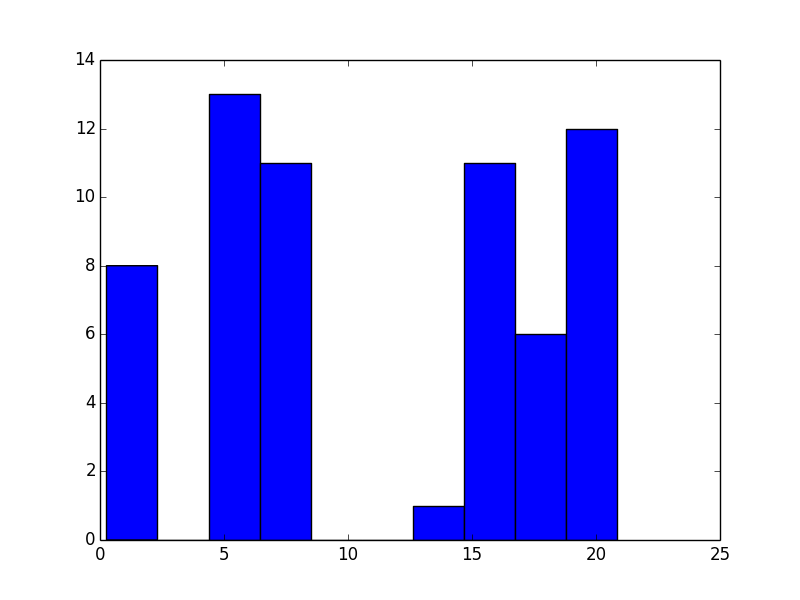

[  1.41421356   8.48528137  21.21320344] [  4.24264069  14.14213562  29.69848481]
[ 2.82842712  5.65685425  8.48528137] widths
[  2.82842712   8.48528137  16.97056275] cumsum
16.9705627485 support_width
[  0.           2.82842712   8.48528137  16.97056275] support_segment_paddings


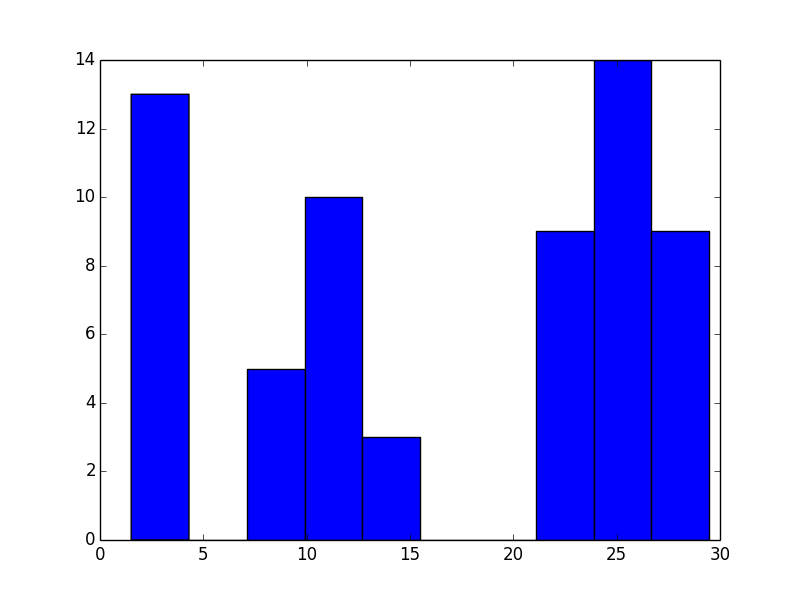

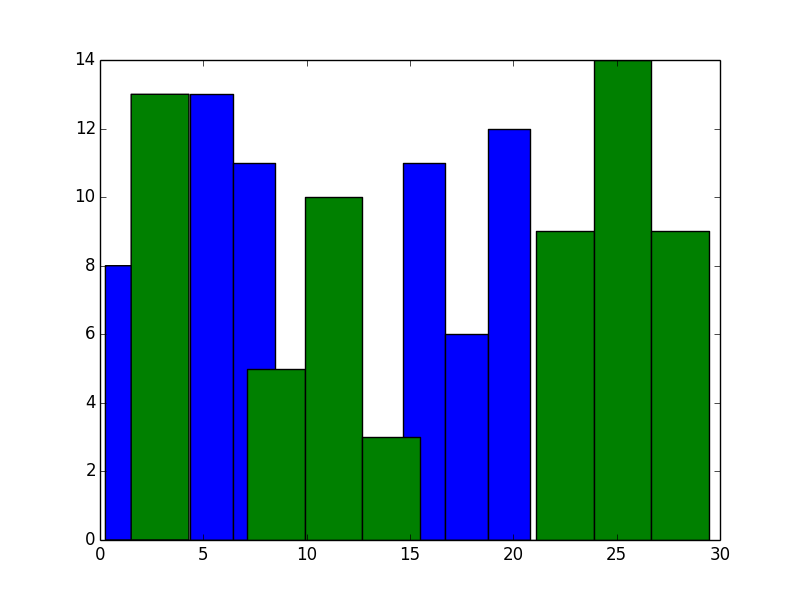

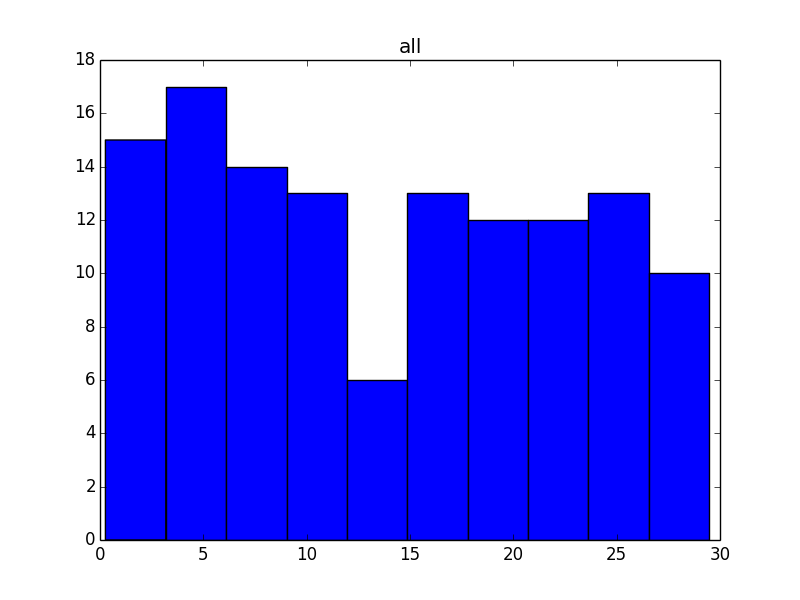

[  0.           4.24264069  14.14213562] [  1.41421356   8.48528137  21.21320344]
[ 1.41421356  4.24264069  7.07106781] widths
[  1.41421356   5.65685425  12.72792206] cumsum
12.7279220614 support_width
[  0.           1.41421356   5.65685425  12.72792206] support_segment_paddings


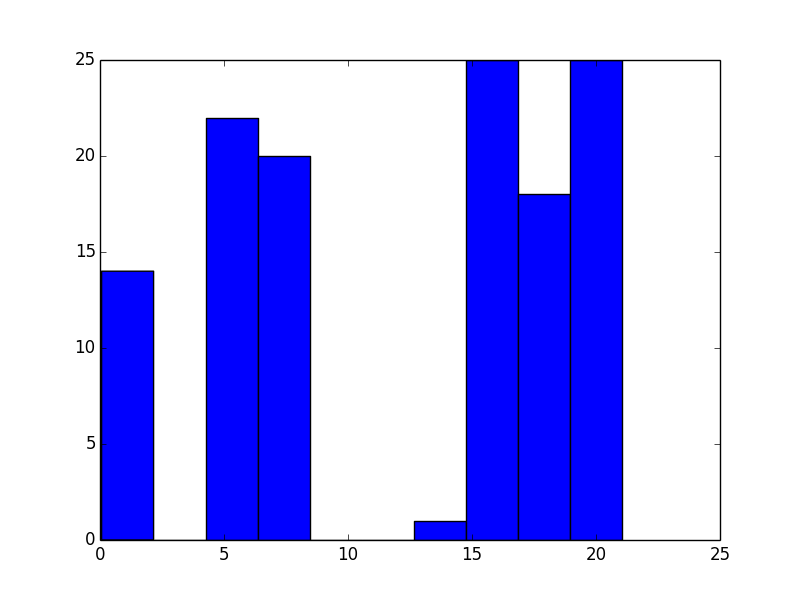

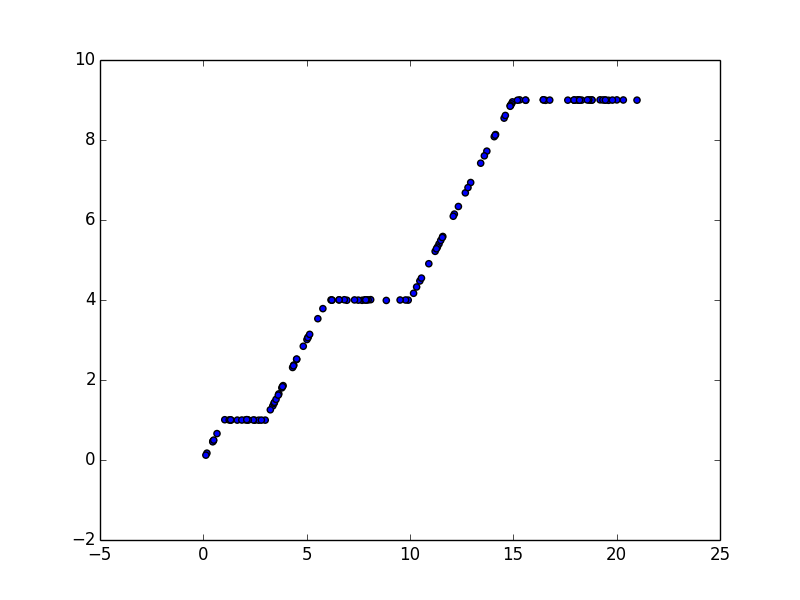

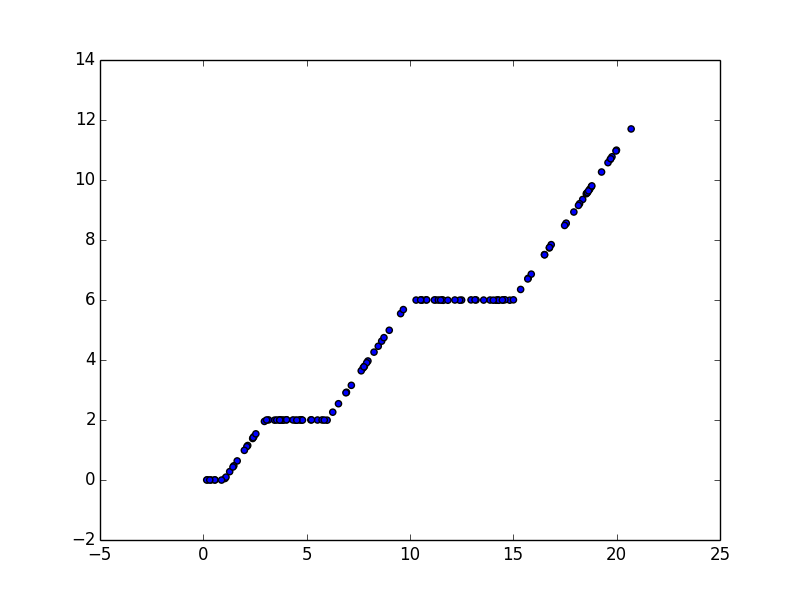

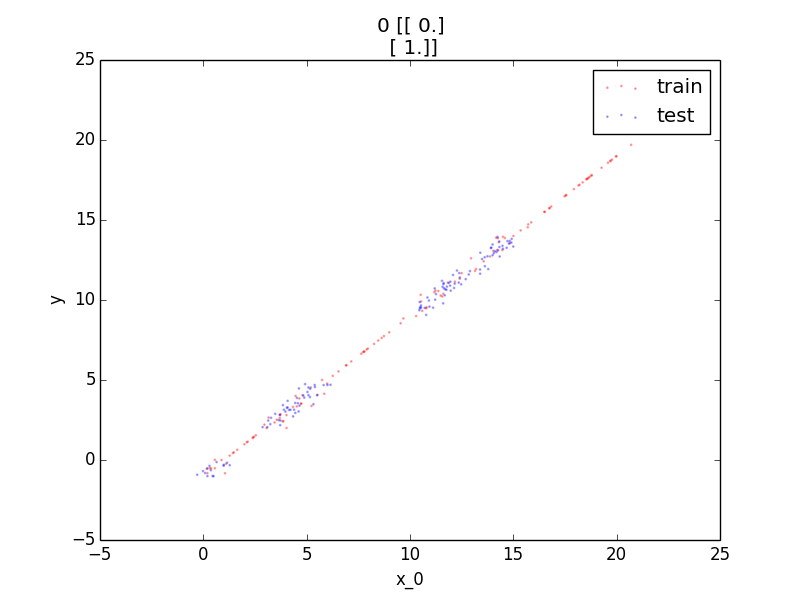

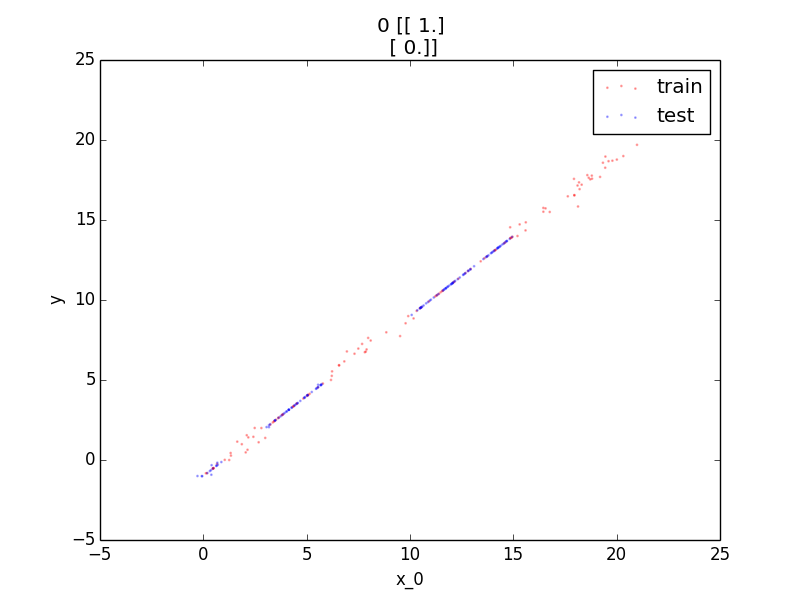

sigma [ 0.25]


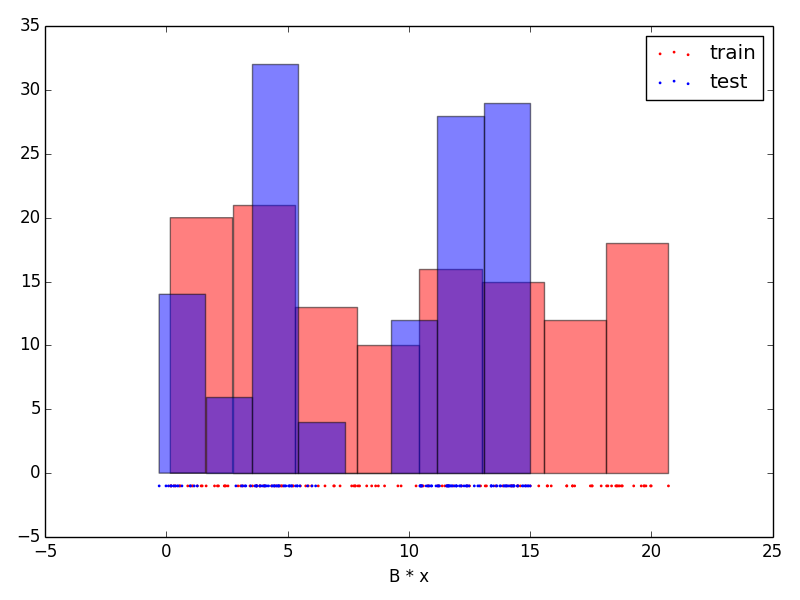

5.0 max pre
4.81995609137 max post
144.862335407 objective
5.0 max pre
4.81995749079 max post
5.0 max pre
4.81995584599 max post
5.0 max pre
4.81995584599 max post
Autograd FloatNode with value 5.0 and 1 tape(s) max pre
Autograd FloatNode with value 4.81995584599 and 1 tape(s) max post
num_tight: 0
solver error: 0.000211472559538
5.0 max pre
4.81995584599 max post
Autograd FloatNode with value 5.0 and 1 tape(s) max pre
Autograd FloatNode with value 4.81995584599 and 1 tape(s) max post
5.0 max pre
4.81995486839 max post
5.0 max pre
4.81995486839 max post
Autograd FloatNode with value 5.0 and 1 tape(s) max pre
Autograd FloatNode with value 4.81995486839 and 1 tape(s) max post
num_tight: 0
solver error: 0.000211472311789
5.0 max pre
4.81995486839 max post
Autograd FloatNode with value 5.0 and 1 tape(s) max pre
Autograd FloatNode with value 4.81995486839 and 1 tape(s) max post
5.0 max pre
4.81995422004 max post
2.96374602286 max pre
2.90494384457 max post
2.96375234228 max pre
2.9049482208

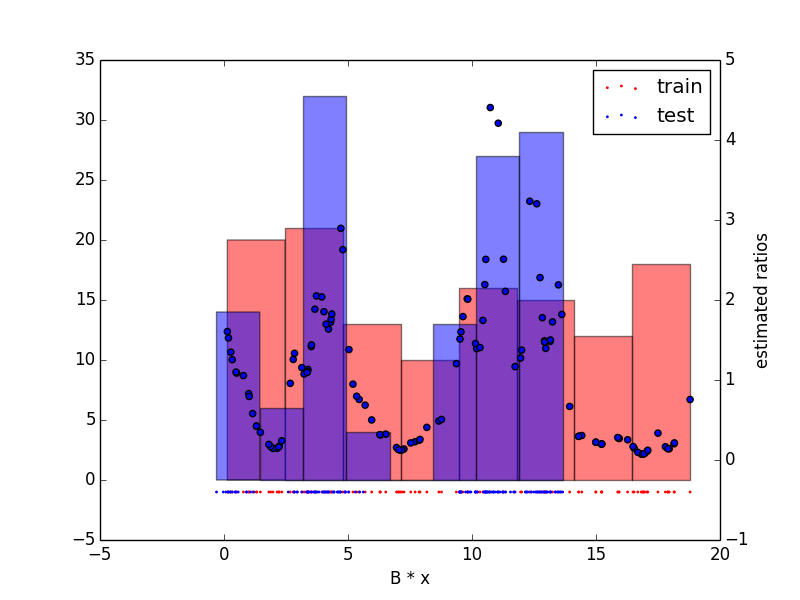

46.9043022012 error
0.0954909152684 B norm


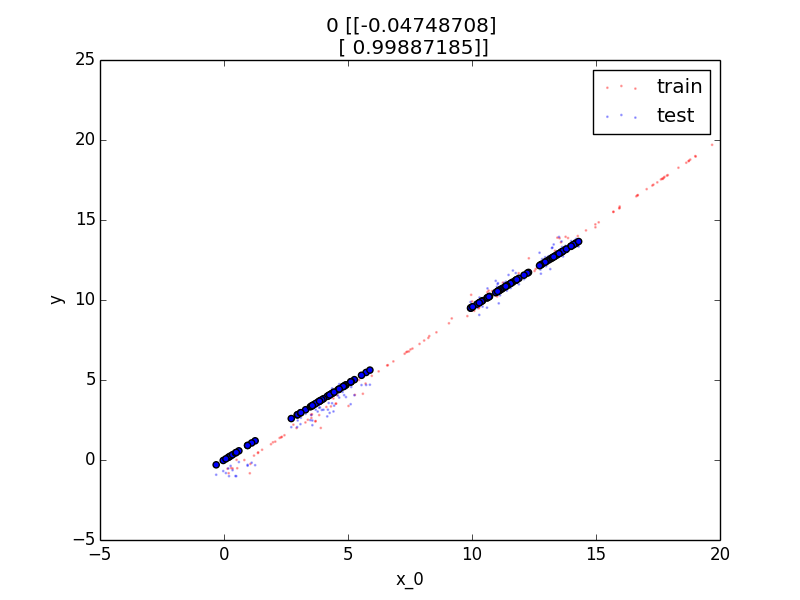

4.56160771624 max pre
4.40566935164 max post
4.56160771624 max pre
4.40566935164 max post
Autograd FloatNode with value 4.56160771624 and 1 tape(s) max pre
Autograd FloatNode with value 4.40566935164 and 1 tape(s) max post
num_tight: 0
solver error: 0.000403138664638
4.56160771624 max pre
4.40566935164 max post
Autograd FloatNode with value 4.56160771624 and 1 tape(s) max pre
Autograd FloatNode with value 4.40566935164 and 1 tape(s) max post
2.18780859799 max pre
2.4977452837 max post
2.18780829123 max pre
2.49774441655 max post
2.18780829123 max pre
2.49774441655 max post
Autograd FloatNode with value 2.18780829123 and 1 tape(s) max pre
Autograd FloatNode with value 2.49774441655 and 1 tape(s) max post
num_tight: 0
solver error: 0.000746221387973
2.18780829123 max pre
2.49774441655 max post
Autograd FloatNode with value 2.18780829123 and 1 tape(s) max pre
Autograd FloatNode with value 2.49774441655 and 1 tape(s) max post
5.0 max pre
4.93615792212 max post
5.0 max pre
4.93615955238 max

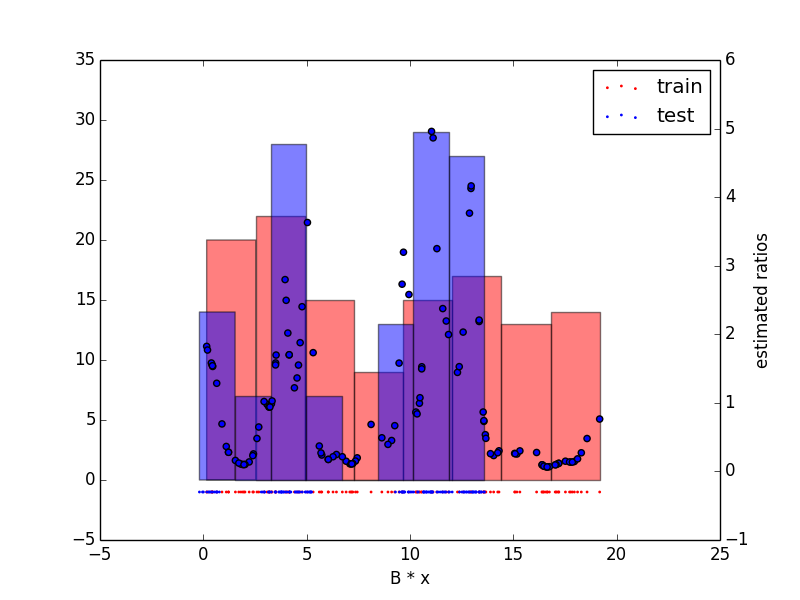

30.3550924823 error
0.0823610143773 B norm


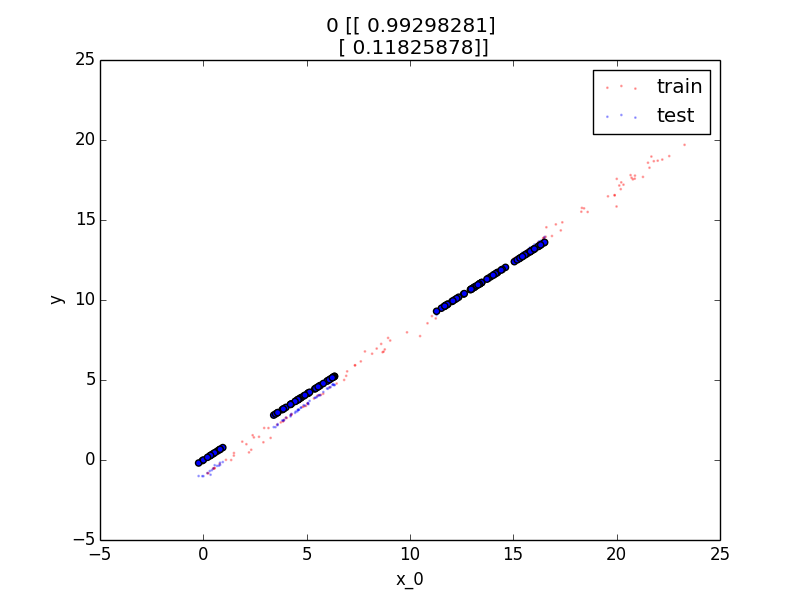

5.0 max pre
4.95867293409 max post
5.0 max pre
4.95867293409 max post
Autograd FloatNode with value 5.0 and 1 tape(s) max pre
Autograd FloatNode with value 4.95867293409 and 1 tape(s) max post
num_tight: 0
solver error: 0.000246336155296
5.0 max pre
4.95867293409 max post
Autograd FloatNode with value 5.0 and 1 tape(s) max pre
Autograd FloatNode with value 4.95867293409 and 1 tape(s) max post
5.0 max pre
4.9586671108 max post
5.0 max pre
4.95866555706 max post
5.0 max pre
4.95866555706 max post
Autograd FloatNode with value 5.0 and 1 tape(s) max pre
Autograd FloatNode with value 4.95866555706 and 1 tape(s) max post
num_tight: 0
solver error: 0.000246230984189
5.0 max pre
4.95866555706 max post
Autograd FloatNode with value 5.0 and 1 tape(s) max pre
Autograd FloatNode with value 4.95866555706 and 1 tape(s) max post
5.0 max pre
4.95866702552 max post
5.0 max pre
4.95866523852 max post
5.0 max pre
4.95866523852 max post
Autograd FloatNode with value 5.0 and 1 tape(s) max pre
Autograd Floa

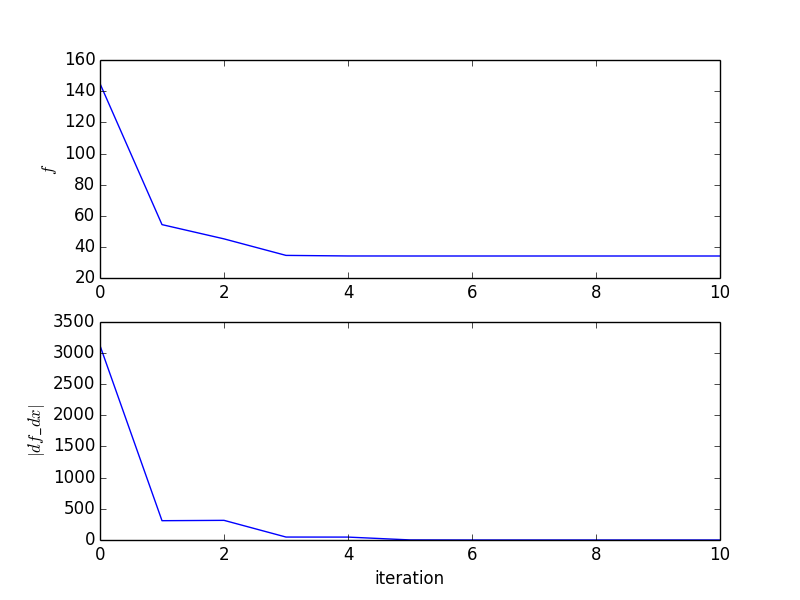

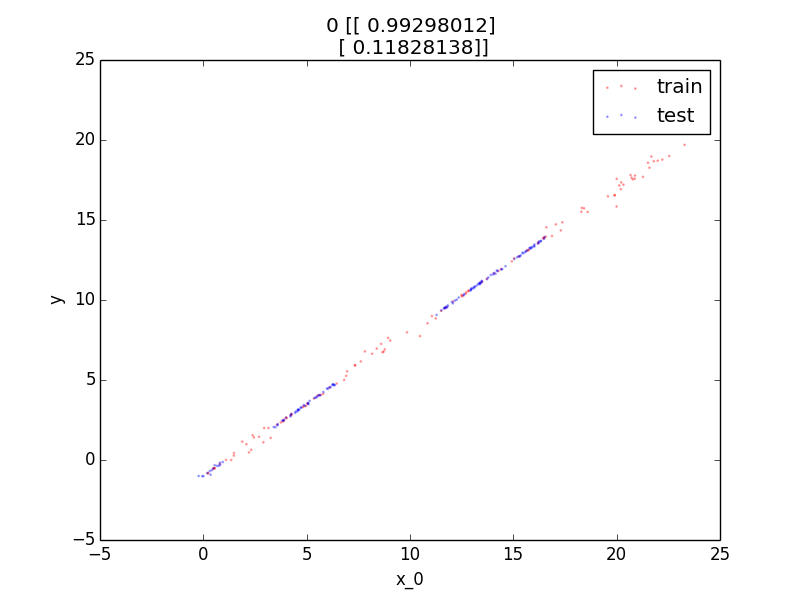

In [11]:
# see if can recover 'true' subspace

np.random.seed(42)

# get data
num_train, num_test = 125, 125

xs_train, xs_test, ys_train, ys_test = data.why_weighting_is_important_data(x_dim=2, num_train=num_train, num_test=num_test)

# plot data
data.data.plot_ys_v_xs(0, xs_train, xs_test, ys_train, ys_test, B=np.array([[0.,1.]]).T)
data.data.plot_ys_v_xs(0, xs_train, xs_test, ys_train, ys_test, B=np.array([[1.,0.]]).T)

# choose hyperparameter sigma
#sigma = np.array([utils.median_distance(np.vstack((xs_train, xs_test)), np.vstack((xs_train, xs_test)))])
sigma = np.array([.25])
print 'sigma', sigma
c_logreg = 1.1
c_B = 0.1

# choose B_init
#B_init = np.random.normal(size=(2,))
#B_init_f = lambda: np.random.normal(size=(2,))
#B_init_f = lambda: np.array([1.,0.])
B_init_f = lambda: np.array([0.,1.])
B_init = B_init_f()

# plot initial projected data
data.data.plot_us(B_init, xs_train, xs_test)

# define optimizer
objective = lambda B: weighted_lsqr_loss_thru_ws_opt_fxn.val(ys_train, xs_train, xs_test, sigma, B, c_logreg, c_B)
dobjective_dB = lambda B: weighted_lsqr_loss_thru_ws_opt_fxn.grad(ys_train, xs_train, xs_test, sigma, B, c_logreg, c_B, care_argnums=(4,))

#weighted_lsqr_loss_thru_ws_opt_fxn.grad_check(ys_train, xs_train, xs_test, sigma, B, care_argnums=(4,))

#assert False
print objective(B_init), 'objective'
#assert False
logreg_ratios_fxn = fxns.two_step( # xs_train, xs_test, sigma, B, c_logreg
    g=b_opt_given_B_fxn, # xs_train, xs_test, sigma, B, c_logreg
    h=fxns.fxn.autograd_fxn(_val=fxns.b_to_logreg_ratios_scale_sigma), # b_logreg, xs_train, xs_test, sigma, B
    g_argnums=(0,1,2,3,4),
    h_argnums=(0,1,2,3),
    g_val_h_argnum=0,
)
def info_f(B):
    ratios = logreg_ratios_fxn.val(xs_train, xs_test, sigma, B, c_logreg)

    fig, ax = plt.subplots()
    data.data.plot_us(B, xs_train, xs_test, ax)
    ratio_ax = ax.twinx()
    ratio_ax.scatter(np.dot(xs_train,B), ratios)
    ratio_ax.set_ylabel('estimated ratios')
    basic.display_fig_inline(fig)
    
    ys_test_hat = np.dot(xs_test, B)
    error = ys_test - ys_test_hat
    #print np.dot(error, error), 'error'
    #pdb.set_trace()
    print np.dot(error,error), 'error'
    print np.linalg.norm(B) * c_B, 'B norm'
    
    #b_opt_given_B_fxn
    
    fig, ax2 = plt.subplots()
    ax2.set_xlim(ax.get_xlim())
    B_normed = B / np.linalg.norm(B)
    data.data.plot_ys_v_xs(0, xs_train, xs_test, ys_train, ys_test, B=B_normed, ax=ax2)
    ys_test_hat = np.dot(xs_test,B)
    ax2.scatter(np.dot(xs_test,B_normed), ys_test_hat, marker='o')
    basic.display_fig_inline(fig)
    
optimizer = optimizers.multiple_optimizer(optimizers.scipy_minimize_optimizer(verbose=5, info_f=info_f), num_tries=1, num_args=1)
u_dim = 1
B_fit = optimizer.optimize(objective, dobjective_dB, B_init_f)
opt_log = optimizer.opt_log
optimizer.plot_objective(opt_log)
real_B_fit = utils.ortho(B_fit.reshape(B_fit.shape+(1,)))
data.data.plot_ys_v_xs(0, xs_train, xs_test, ys_train, ys_test, B=real_B_fit)

In [7]:
def f(inst,z):
    print inst
    print f
    print inst.x, inst.y, z

class asdf(object):
    
    def __init__(self):
        self.x, self.y = 1,2
    
    f = f
    

    
inst = asdf()
inst.f(45)

<function f at 0x11aa27f50>
1 2 45


[ 3 10 21] v1_constant_right_axis_boundaries
[ 1  6 15] v1_constant_left_axis_boundaries
[  0.           4.24264069  14.14213562] [  1.41421356   8.48528137  21.21320344]
[ 1.41421356  4.24264069  7.07106781] widths
[  1.41421356   5.65685425  12.72792206] cumsum
12.7279220614 support_width
[  0.           1.41421356   5.65685425  12.72792206] support_segment_paddings


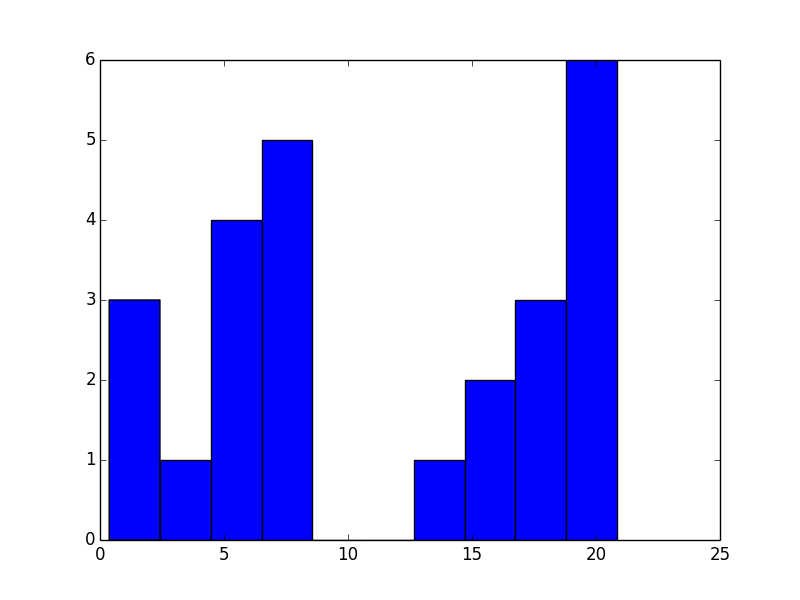

[  1.41421356   8.48528137  21.21320344] [  4.24264069  14.14213562  29.69848481]
[ 2.82842712  5.65685425  8.48528137] widths
[  2.82842712   8.48528137  16.97056275] cumsum
16.9705627485 support_width
[  0.           2.82842712   8.48528137  16.97056275] support_segment_paddings


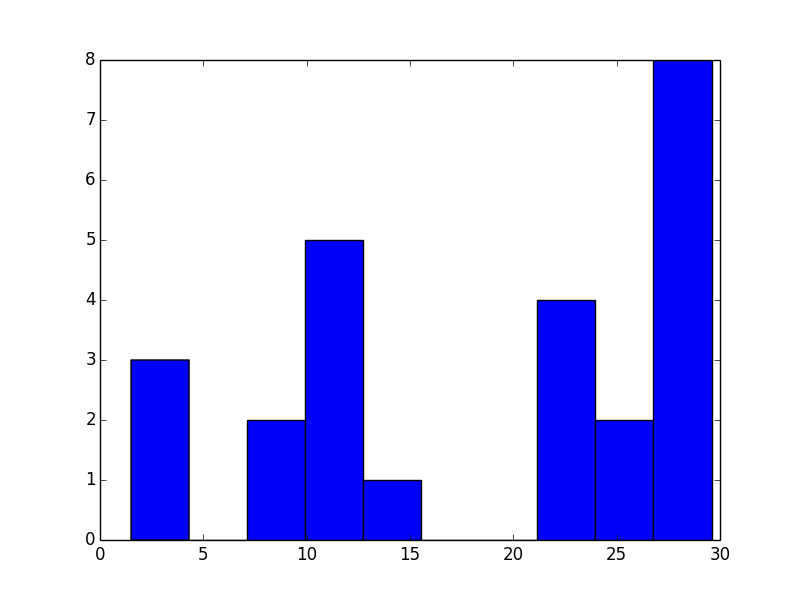

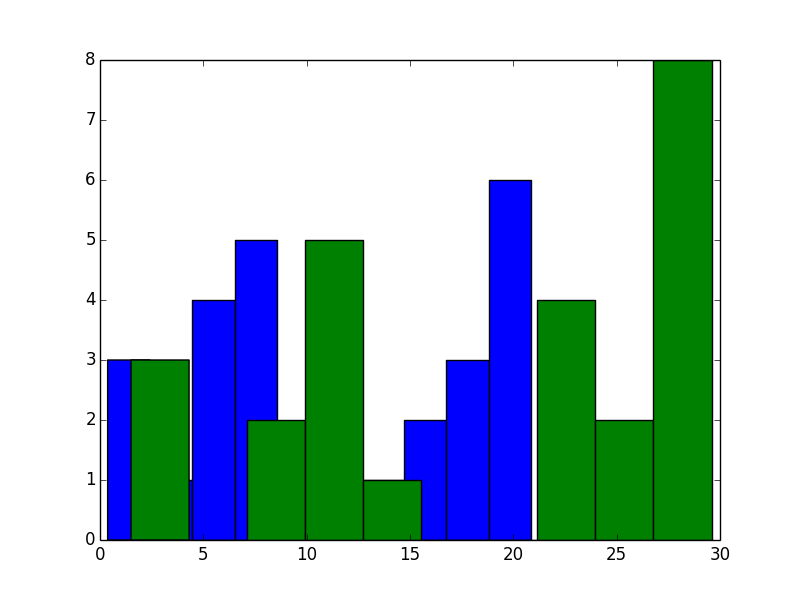

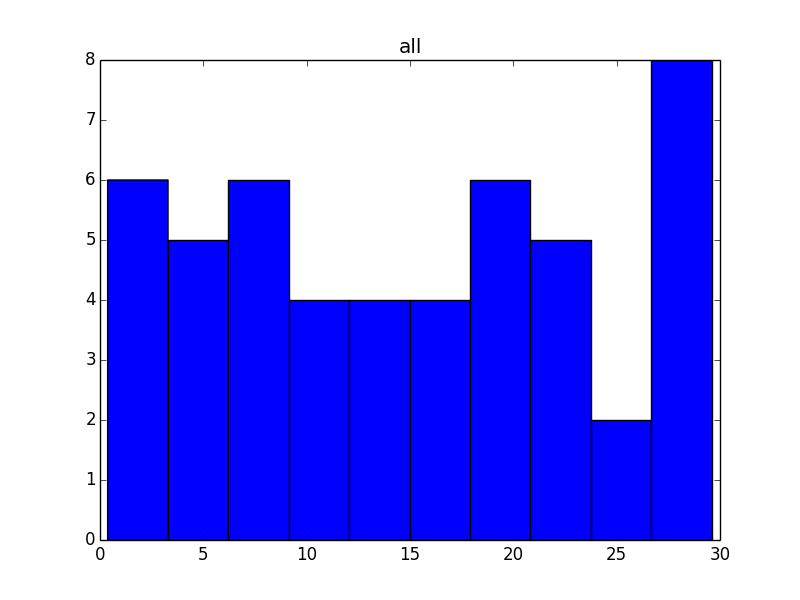

[  0.           4.24264069  14.14213562] [  1.41421356   8.48528137  21.21320344]
[ 1.41421356  4.24264069  7.07106781] widths
[  1.41421356   5.65685425  12.72792206] cumsum
12.7279220614 support_width
[  0.           1.41421356   5.65685425  12.72792206] support_segment_paddings


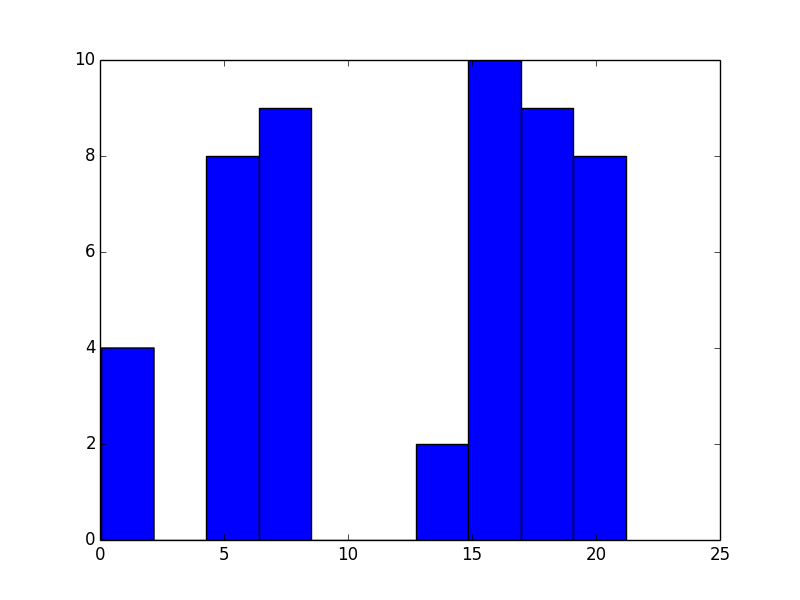

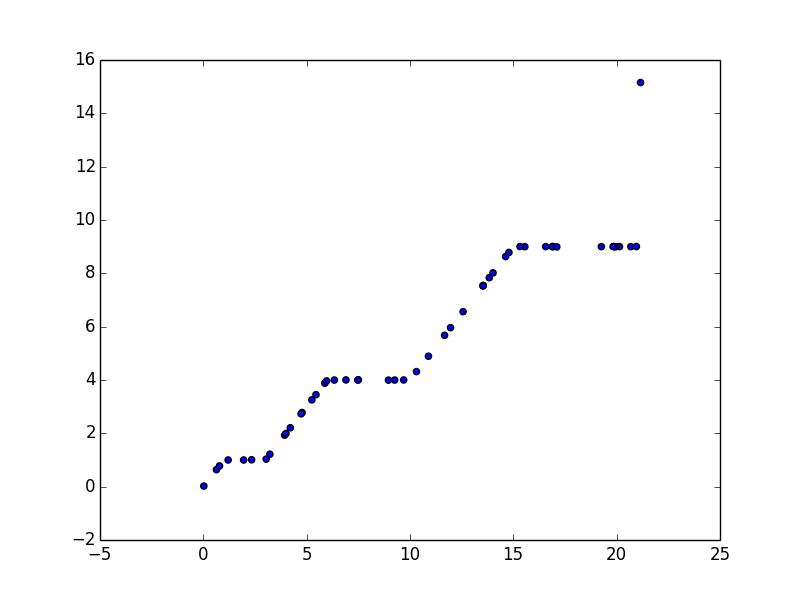

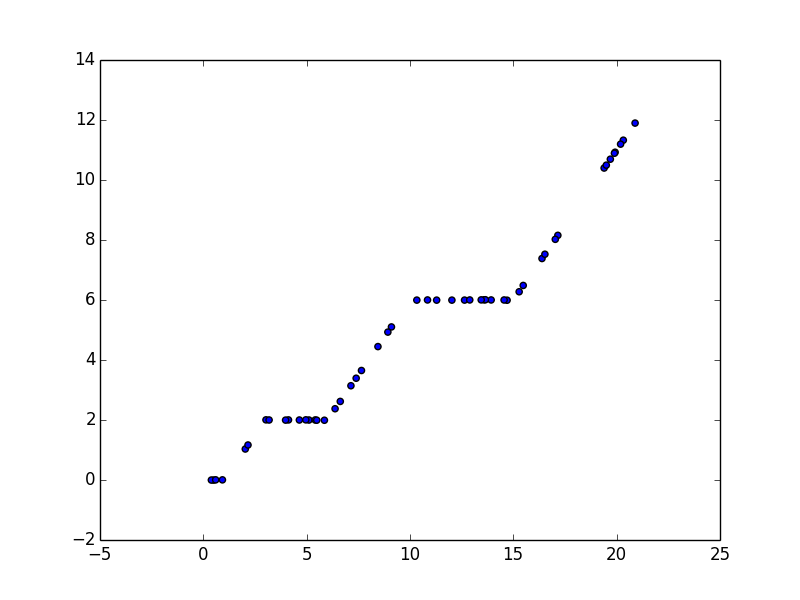

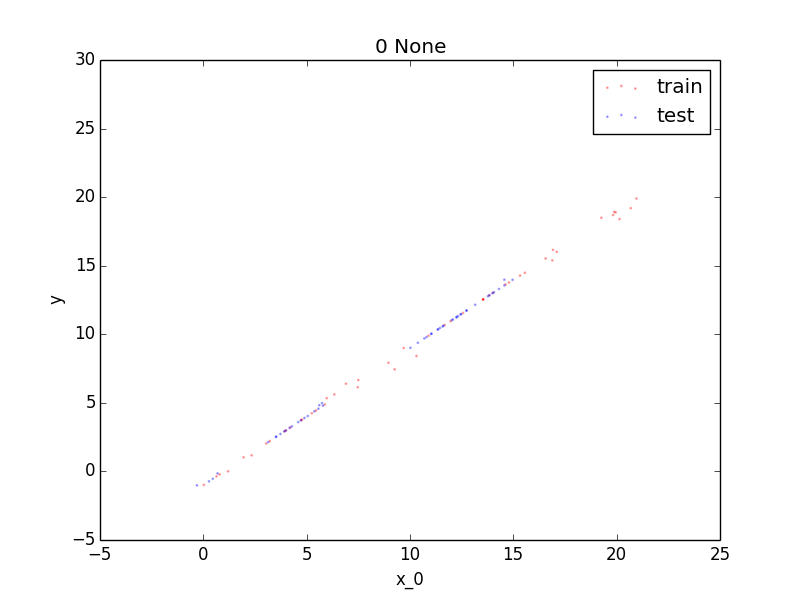

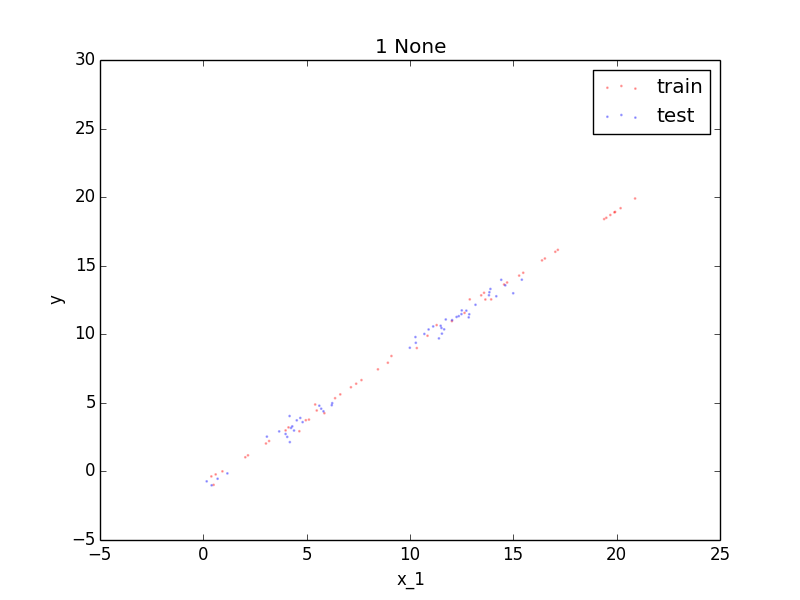

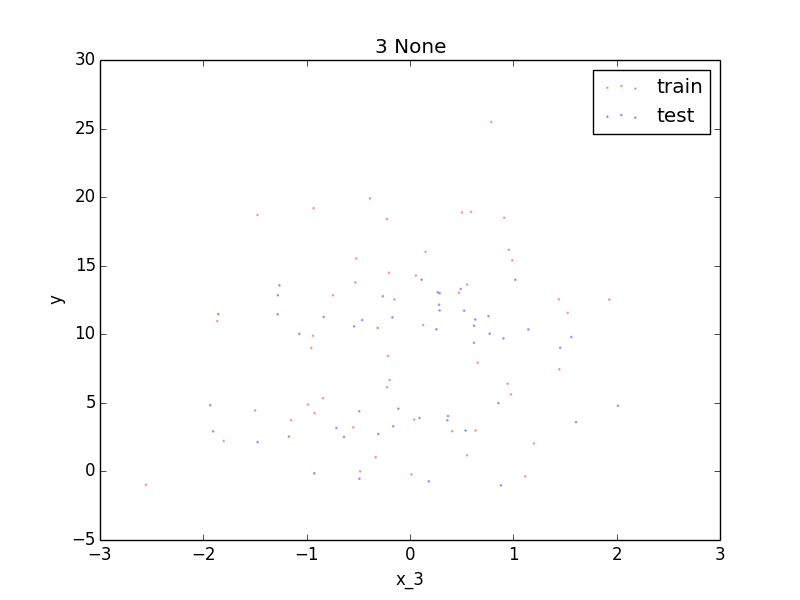

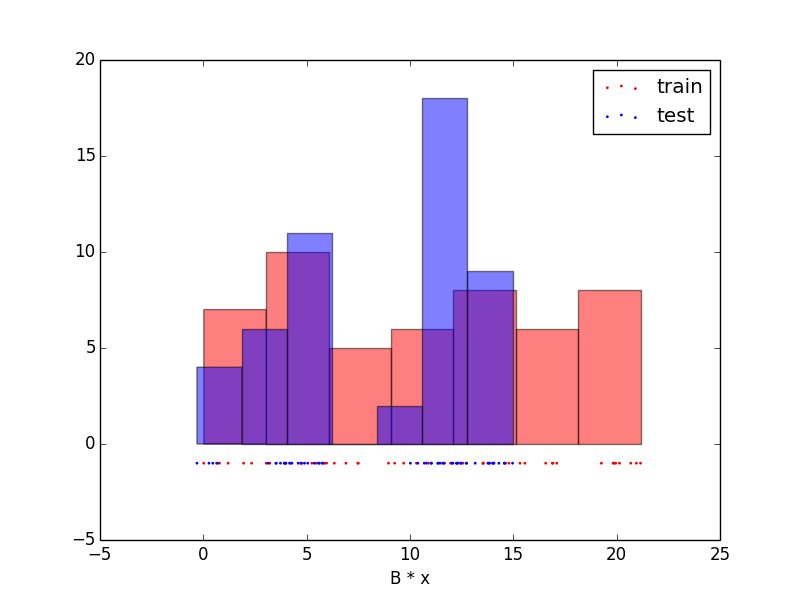

(50, 50) (50, 50) (50,) (50,)
21.1552575033 0.0238307332959
[ 0.25] sigma
2.0 max pre
2.11032214466 max post
2.0 max pre
2.11032177656 max post
2.0 max pre
2.11032177656 max post
Autograd FloatNode with value 2.0 and 1 tape(s) max pre
Autograd FloatNode with value 2.11032177656 and 1 tape(s) max post
num_tight: 0
solver error: 3.79436192306e-05
2.0 max pre
2.11032177656 max post
Autograd FloatNode with value 2.0 and 1 tape(s) max pre
Autograd FloatNode with value 2.11032177656 and 1 tape(s) max post
2.0 max pre
2.1103224377 max post
2.0 max pre
2.1103224377 max post
Autograd FloatNode with value 2.0 and 1 tape(s) max pre
Autograd FloatNode with value 2.1103224377 and 1 tape(s) max post
num_tight: 0
solver error: 3.7943821437e-05
2.0 max pre
2.1103224377 max post
Autograd FloatNode with value 2.0 and 1 tape(s) max pre
Autograd FloatNode with value 2.1103224377 and 1 tape(s) max post
2.0 max pre
2.11032219682 max post
2.0 max pre
2.36082355643 max post
2.0 max pre
2.3608228459 max post
2

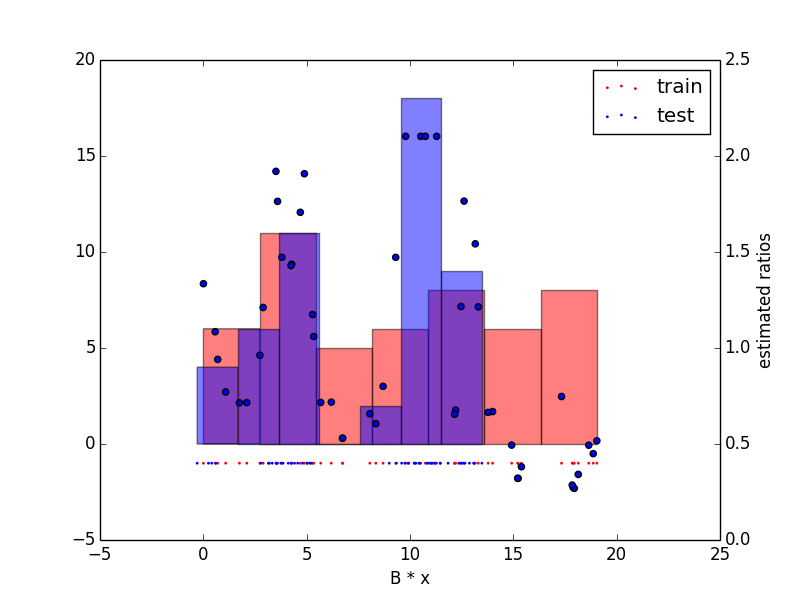

10.5139452861 error
141.492248332 B norm


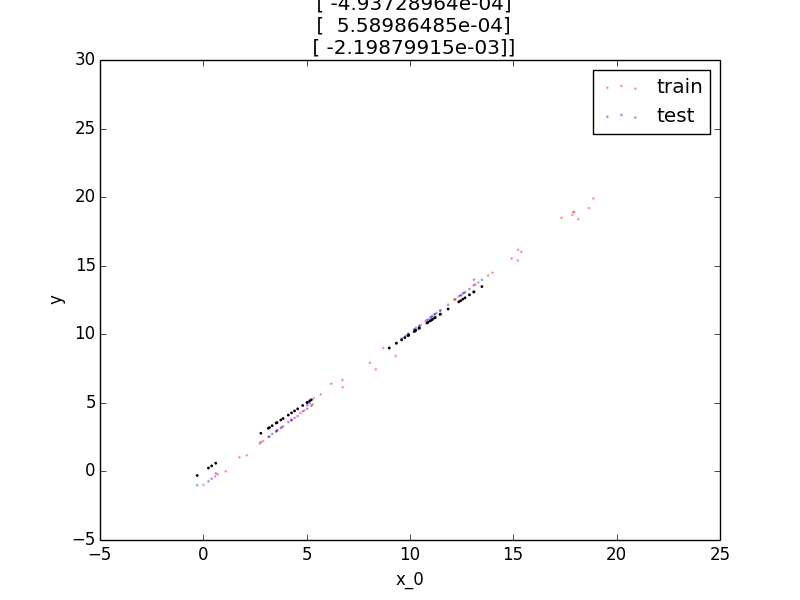

2.0 max pre
2.10239809967 max post
2.0 max pre
2.10239809967 max post
Autograd FloatNode with value 2.0 and 1 tape(s) max pre
Autograd FloatNode with value 2.10239809967 and 1 tape(s) max post
num_tight: 0
solver error: 0.000230901746516
2.0 max pre
2.10239809967 max post
Autograd FloatNode with value 2.0 and 1 tape(s) max pre
Autograd FloatNode with value 2.10239809967 and 1 tape(s) max post
2.0 max pre
2.15333601001 max post
2.0 max pre
2.15333560728 max post
2.0 max pre
2.15333560728 max post
Autograd FloatNode with value 2.0 and 1 tape(s) max pre
Autograd FloatNode with value 2.15333560728 and 1 tape(s) max post
num_tight: 0
solver error: 0.000158744780436
2.0 max pre
2.15333560728 max post
Autograd FloatNode with value 2.0 and 1 tape(s) max pre
Autograd FloatNode with value 2.15333560728 and 1 tape(s) max post
2.0 max pre
2.15333596809 max post
2.0 max pre
2.15333461329 max post
2.0 max pre
2.15333461329 max post
Autograd FloatNode with value 2.0 and 1 tape(s) max pre
Autograd Flo

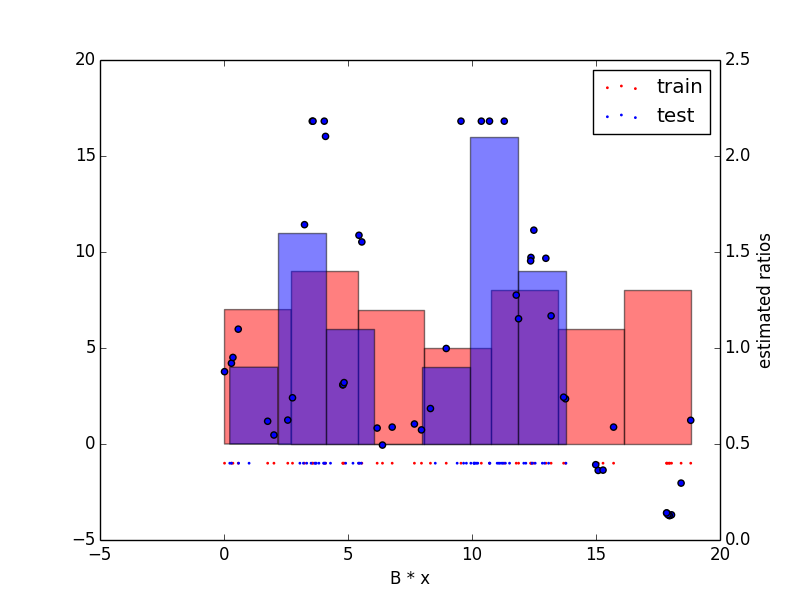

17.6868024209 error
99.9121438698 B norm


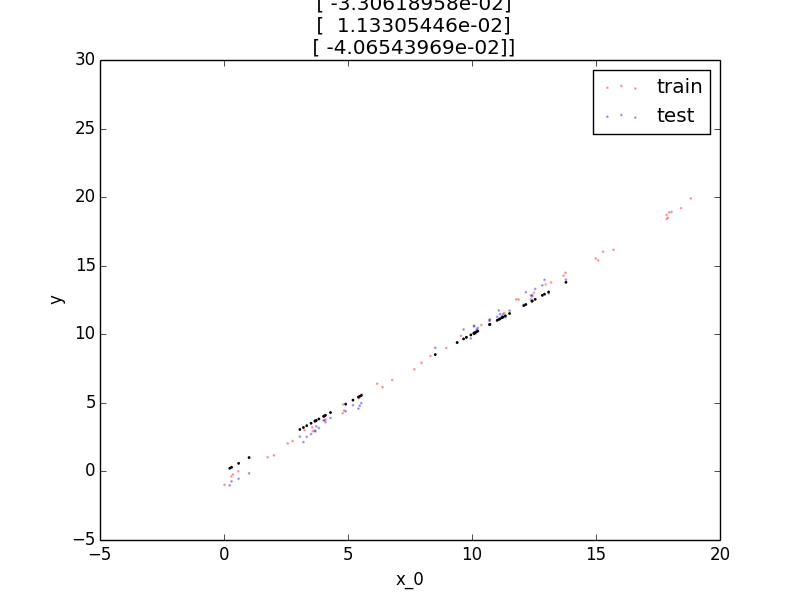

2.0 max pre
2.1814404092 max post
2.0 max pre
2.1814404092 max post
Autograd FloatNode with value 2.0 and 1 tape(s) max pre
Autograd FloatNode with value 2.1814404092 and 1 tape(s) max post
num_tight: 0
solver error: 4.66685781681e-05
2.0 max pre
2.1814404092 max post
Autograd FloatNode with value 2.0 and 1 tape(s) max pre
Autograd FloatNode with value 2.1814404092 and 1 tape(s) max post
2.0 max pre
2.22157941112 max post
2.0 max pre
2.22158062993 max post
2.0 max pre
2.22158062993 max post
Autograd FloatNode with value 2.0 and 1 tape(s) max pre
Autograd FloatNode with value 2.22158062993 and 1 tape(s) max post
num_tight: 0
solver error: 8.98458052914e-05
2.0 max pre
2.22158062993 max post
Autograd FloatNode with value 2.0 and 1 tape(s) max pre
Autograd FloatNode with value 2.22158062993 and 1 tape(s) max post
2.0 max pre
2.18005259312 max post
2.0 max pre
2.18005327816 max post
2.0 max pre
2.18005327816 max post
Autograd FloatNode with value 2.0 and 1 tape(s) max pre
Autograd FloatNod

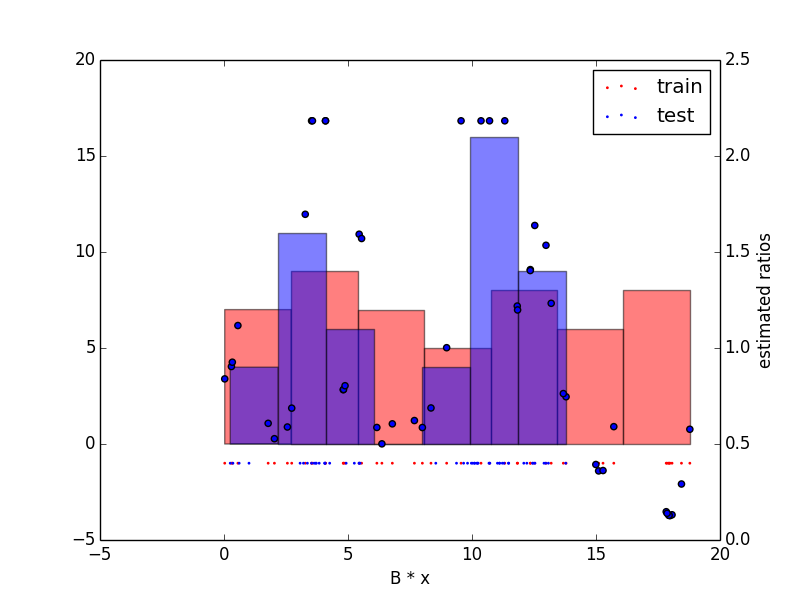

17.7740057729 error
99.8979074487 B norm


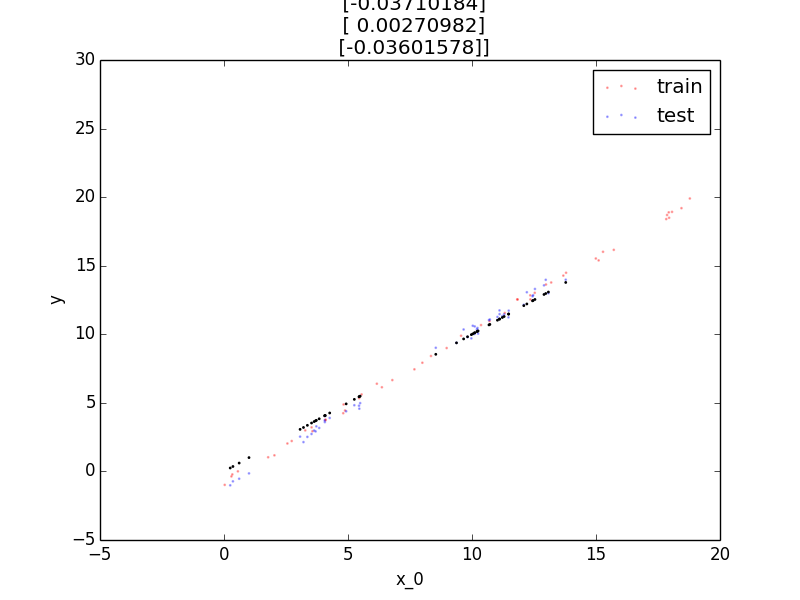

2.0 max pre
2.18327695867 max post
2.0 max pre
2.18327695867 max post
Autograd FloatNode with value 2.0 and 1 tape(s) max pre
Autograd FloatNode with value 2.18327695867 and 1 tape(s) max post
num_tight: 0
solver error: 4.61347669139e-05
2.0 max pre
2.18327695867 max post
Autograd FloatNode with value 2.0 and 1 tape(s) max pre
Autograd FloatNode with value 2.18327695867 and 1 tape(s) max post
2.0 max pre
2.18391711353 max post
2.0 max pre
2.18391805602 max post
2.0 max pre
2.18391805602 max post
Autograd FloatNode with value 2.0 and 1 tape(s) max pre
Autograd FloatNode with value 2.18391805602 and 1 tape(s) max post
num_tight: 0
solver error: 4.65844726096e-05
2.0 max pre
2.18391805602 max post
Autograd FloatNode with value 2.0 and 1 tape(s) max pre
Autograd FloatNode with value 2.18391805602 and 1 tape(s) max post
2.0 max pre
2.18391732076 max post
2.0 max pre
2.18391660799 max post
2.0 max pre
2.18391660799 max post
Autograd FloatNode with value 2.0 and 1 tape(s) max pre
Autograd Flo

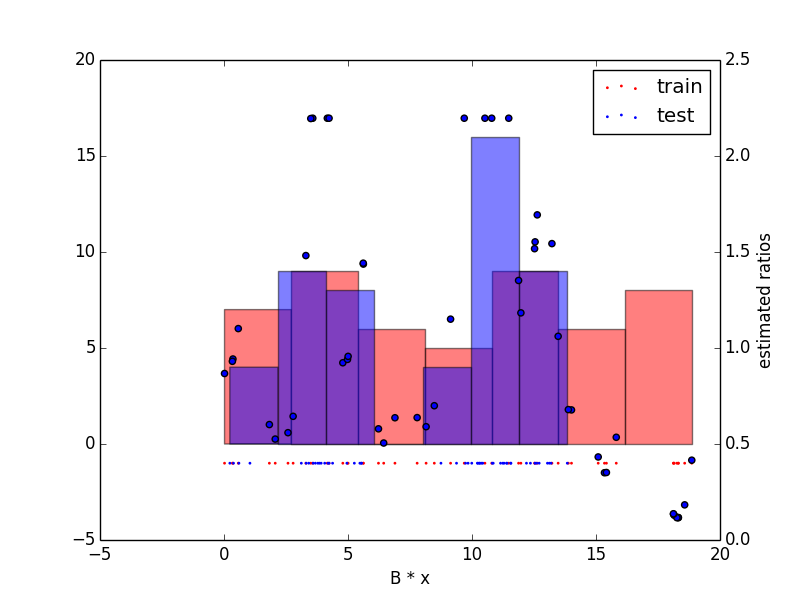

17.3972323086 error
100.469032326 B norm


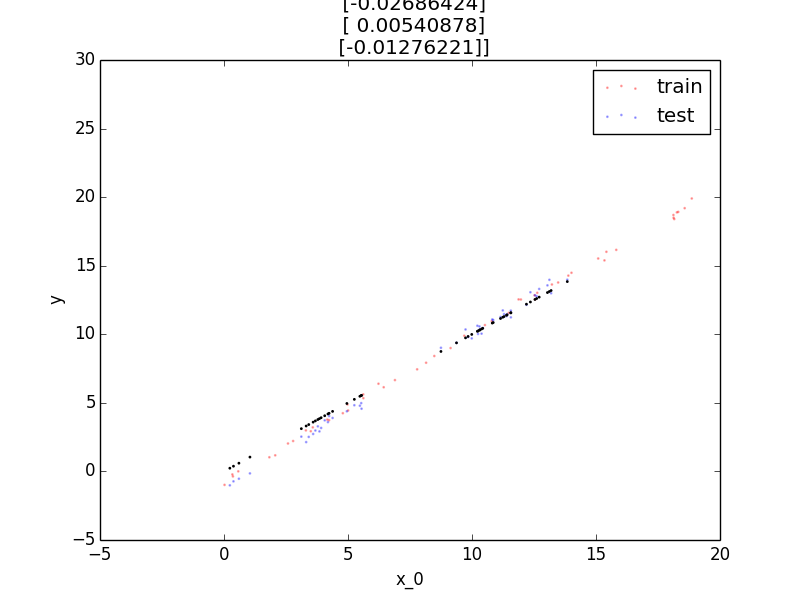

2.0 max pre
2.19678552652 max post
2.0 max pre
2.19678552652 max post
Autograd FloatNode with value 2.0 and 1 tape(s) max pre
Autograd FloatNode with value 2.19678552652 and 1 tape(s) max post
num_tight: 0
solver error: 6.97694048851e-05
2.0 max pre
2.19678552652 max post
Autograd FloatNode with value 2.0 and 1 tape(s) max pre
Autograd FloatNode with value 2.19678552652 and 1 tape(s) max post
2.0 max pre
2.21479040445 max post
2.0 max pre
2.21479122055 max post
2.0 max pre
2.21479122055 max post
Autograd FloatNode with value 2.0 and 1 tape(s) max pre
Autograd FloatNode with value 2.21479122055 and 1 tape(s) max post
num_tight: 0
solver error: 6.72868124139e-05
2.0 max pre
2.21479122055 max post
Autograd FloatNode with value 2.0 and 1 tape(s) max pre
Autograd FloatNode with value 2.21479122055 and 1 tape(s) max post
2.0 max pre
2.20244986126 max post
2.0 max pre
2.20245081893 max post
2.0 max pre
2.20245081893 max post
Autograd FloatNode with value 2.0 and 1 tape(s) max pre
Autograd Flo

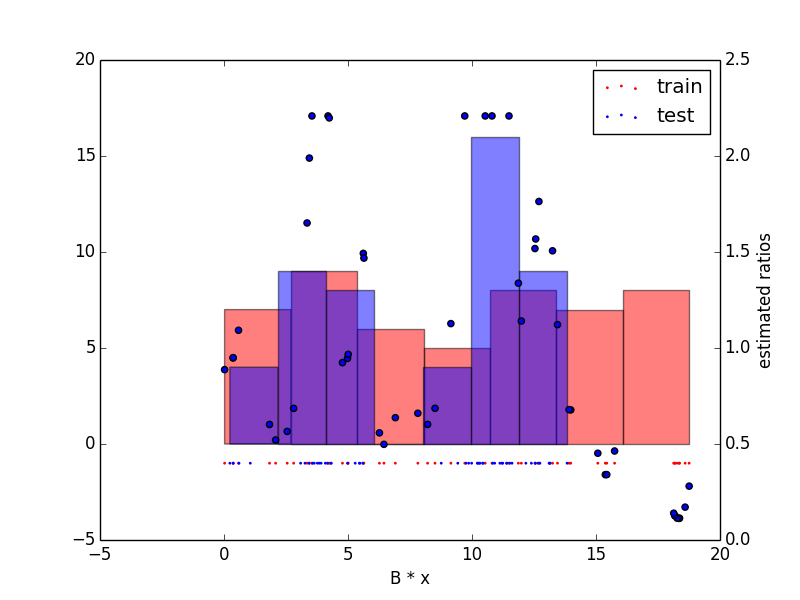

17.0353711217 error
100.358179887 B norm


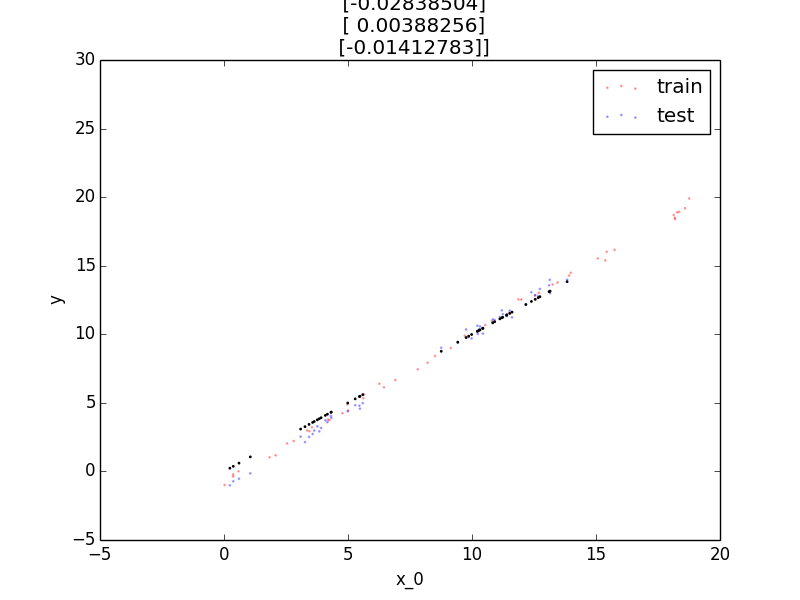

2.0 max pre
2.20864495156 max post
2.0 max pre
2.20864495156 max post
Autograd FloatNode with value 2.0 and 1 tape(s) max pre
Autograd FloatNode with value 2.20864495156 and 1 tape(s) max post
num_tight: 0
solver error: 7.98802466876e-05
2.0 max pre
2.20864495156 max post
Autograd FloatNode with value 2.0 and 1 tape(s) max pre
Autograd FloatNode with value 2.20864495156 and 1 tape(s) max post
2.0 max pre
2.20240378387 max post
2.0 max pre
2.20240346262 max post
2.0 max pre
2.20240346262 max post
Autograd FloatNode with value 2.0 and 1 tape(s) max pre
Autograd FloatNode with value 2.20240346262 and 1 tape(s) max post
num_tight: 0
solver error: 4.73499188235e-05
2.0 max pre
2.20240346262 max post
Autograd FloatNode with value 2.0 and 1 tape(s) max pre
Autograd FloatNode with value 2.20240346262 and 1 tape(s) max post
2.0 max pre
2.20730778314 max post
2.0 max pre
2.20730782183 max post
2.0 max pre
2.20730782183 max post
Autograd FloatNode with value 2.0 and 1 tape(s) max pre
Autograd Flo

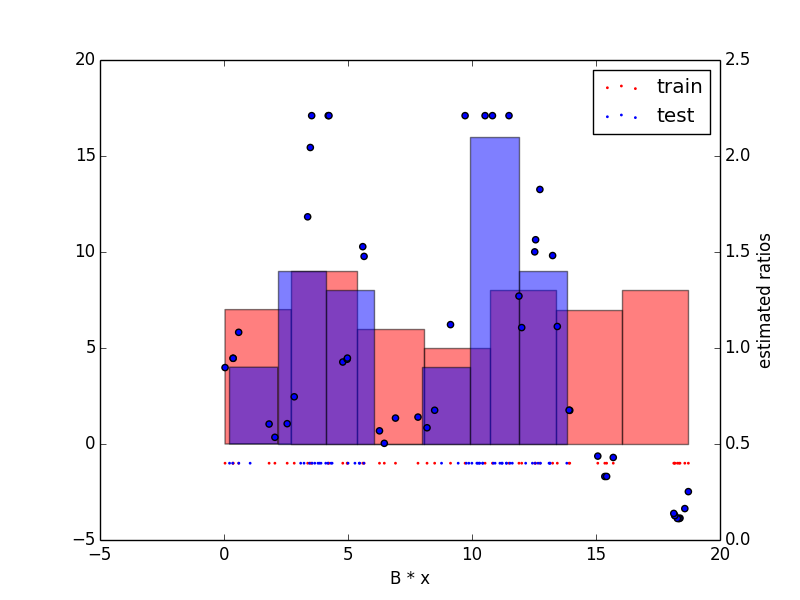

16.893228452 error
100.186188321 B norm


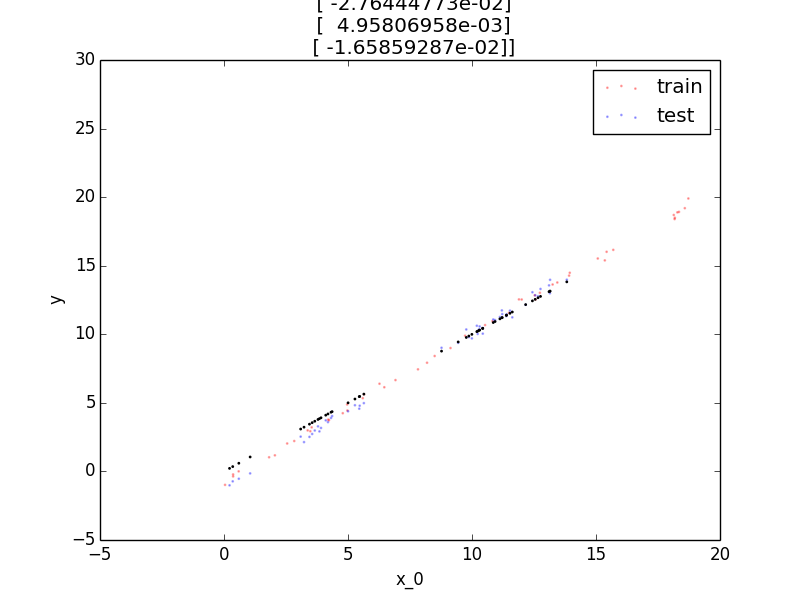

2.0 max pre
2.21018649228 max post
2.0 max pre
2.21018649228 max post
Autograd FloatNode with value 2.0 and 1 tape(s) max pre
Autograd FloatNode with value 2.21018649228 and 1 tape(s) max post
num_tight: 0
solver error: 9.0525359619e-05
2.0 max pre
2.21018649228 max post
Autograd FloatNode with value 2.0 and 1 tape(s) max pre
Autograd FloatNode with value 2.21018649228 and 1 tape(s) max post
2.0 max pre
2.29141451715 max post
2.0 max pre
2.29141498126 max post
2.0 max pre
2.29141498126 max post
Autograd FloatNode with value 2.0 and 1 tape(s) max pre
Autograd FloatNode with value 2.29141498126 and 1 tape(s) max post
num_tight: 0
solver error: 8.33996037469e-05
2.0 max pre
2.29141498126 max post
Autograd FloatNode with value 2.0 and 1 tape(s) max pre
Autograd FloatNode with value 2.29141498126 and 1 tape(s) max post
2.0 max pre
2.22019940632 max post
2.0 max pre
2.22019901626 max post
2.0 max pre
2.22019901626 max post
Autograd FloatNode with value 2.0 and 1 tape(s) max pre
Autograd Floa

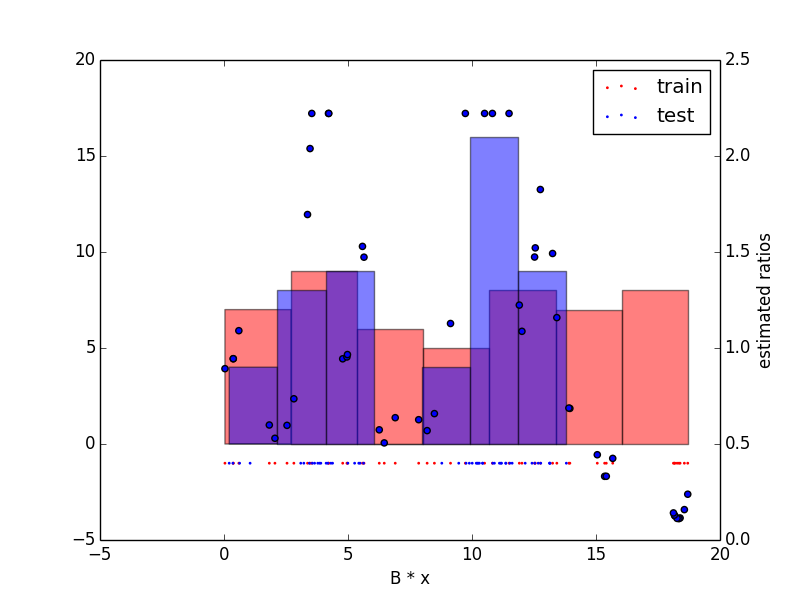

17.0033223623 error
100.095854502 B norm


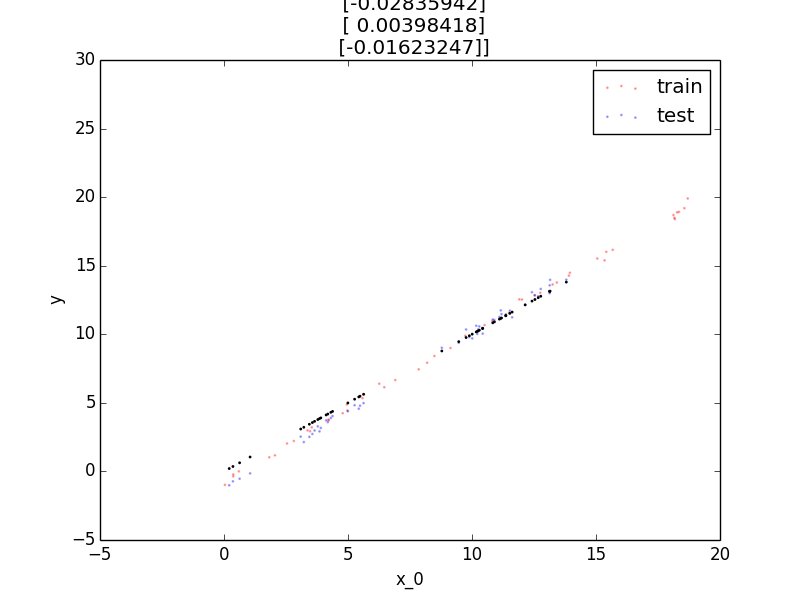

2.0 max pre
2.2217080189 max post
2.0 max pre
2.2217080189 max post
Autograd FloatNode with value 2.0 and 1 tape(s) max pre
Autograd FloatNode with value 2.2217080189 and 1 tape(s) max post
num_tight: 0
solver error: 9.45356270117e-05
2.0 max pre
2.2217080189 max post
Autograd FloatNode with value 2.0 and 1 tape(s) max pre
Autograd FloatNode with value 2.2217080189 and 1 tape(s) max post
2.0 max pre
2.27512909631 max post
2.0 max pre
2.27512958454 max post
2.0 max pre
2.27512958454 max post
Autograd FloatNode with value 2.0 and 1 tape(s) max pre
Autograd FloatNode with value 2.27512958454 and 1 tape(s) max post
num_tight: 0
solver error: 8.40364064518e-05
2.0 max pre
2.27512958454 max post
Autograd FloatNode with value 2.0 and 1 tape(s) max pre
Autograd FloatNode with value 2.27512958454 and 1 tape(s) max post
2.0 max pre
2.2231581645 max post
2.0 max pre
2.22315950592 max post
2.0 max pre
2.22315950592 max post
Autograd FloatNode with value 2.0 and 1 tape(s) max pre
Autograd FloatNode

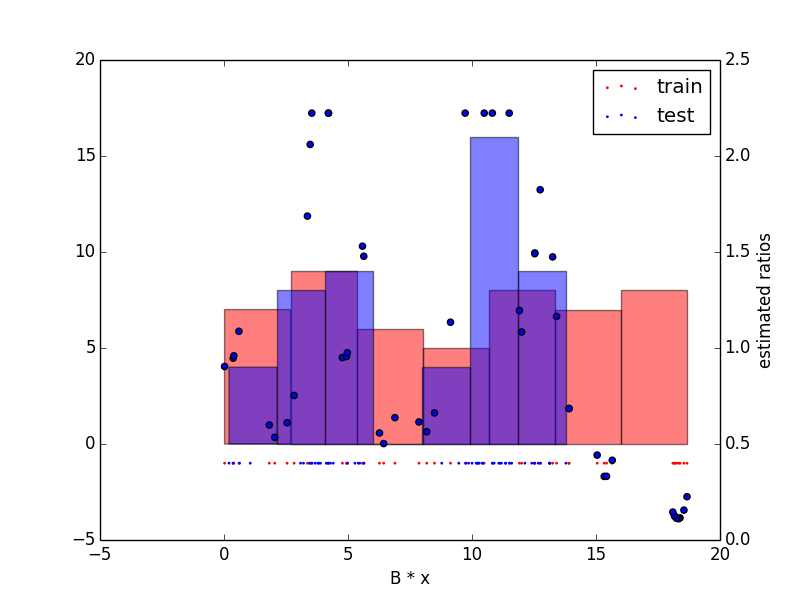

16.9779853603 error
99.9818960809 B norm


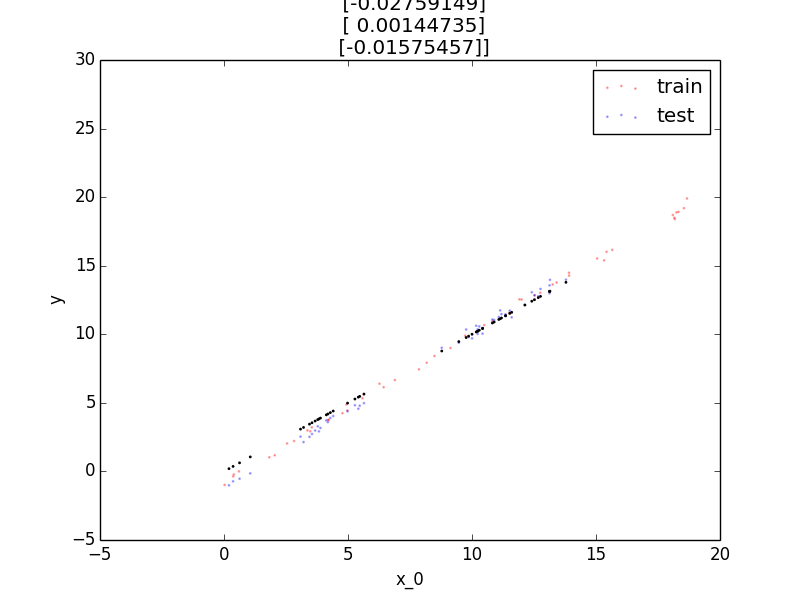

2.0 max pre
2.22333238478 max post
2.0 max pre
2.22333238478 max post
Autograd FloatNode with value 2.0 and 1 tape(s) max pre
Autograd FloatNode with value 2.22333238478 and 1 tape(s) max post
num_tight: 0
solver error: 8.55187490984e-05
2.0 max pre
2.22333238478 max post
Autograd FloatNode with value 2.0 and 1 tape(s) max pre
Autograd FloatNode with value 2.22333238478 and 1 tape(s) max post
2.0 max pre
2.22142175539 max post
2.0 max pre
2.22142124966 max post
2.0 max pre
2.22142124966 max post
Autograd FloatNode with value 2.0 and 1 tape(s) max pre
Autograd FloatNode with value 2.22142124966 and 1 tape(s) max post
num_tight: 0
solver error: 8.93089418099e-05
2.0 max pre
2.22142124966 max post
Autograd FloatNode with value 2.0 and 1 tape(s) max pre
Autograd FloatNode with value 2.22142124966 and 1 tape(s) max post
2.0 max pre
2.22324198334 max post
2.0 max pre
2.22324286871 max post
2.0 max pre
2.22324286871 max post
Autograd FloatNode with value 2.0 and 1 tape(s) max pre
Autograd Flo

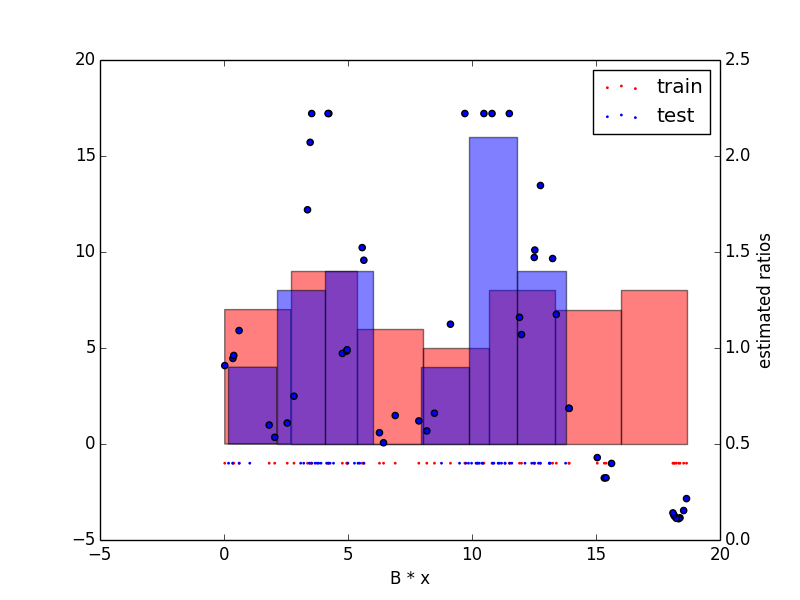

16.8795702137 error
99.9378034378 B norm


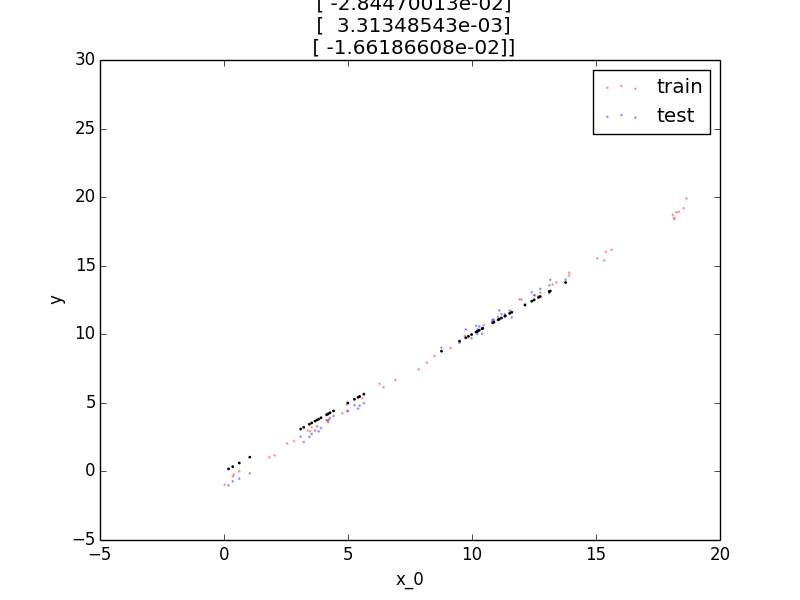

2.0 max pre
2.22125453095 max post
2.0 max pre
2.22125453095 max post
Autograd FloatNode with value 2.0 and 1 tape(s) max pre
Autograd FloatNode with value 2.22125453095 and 1 tape(s) max post
num_tight: 0
solver error: 8.76186765345e-05
2.0 max pre
2.22125453095 max post
Autograd FloatNode with value 2.0 and 1 tape(s) max pre
Autograd FloatNode with value 2.22125453095 and 1 tape(s) max post
2.0 max pre
2.22124014212 max post
2.0 max pre
2.22123840037 max post
2.0 max pre
2.22123840037 max post
Autograd FloatNode with value 2.0 and 1 tape(s) max pre
Autograd FloatNode with value 2.22123840037 and 1 tape(s) max post
num_tight: 0
solver error: 8.76670526413e-05
2.0 max pre
2.22123840037 max post
Autograd FloatNode with value 2.0 and 1 tape(s) max pre
Autograd FloatNode with value 2.22123840037 and 1 tape(s) max post
2.0 max pre
2.22117501124 max post
2.0 max pre
2.22117490649 max post
2.0 max pre
2.22117490649 max post
Autograd FloatNode with value 2.0 and 1 tape(s) max pre
Autograd Flo

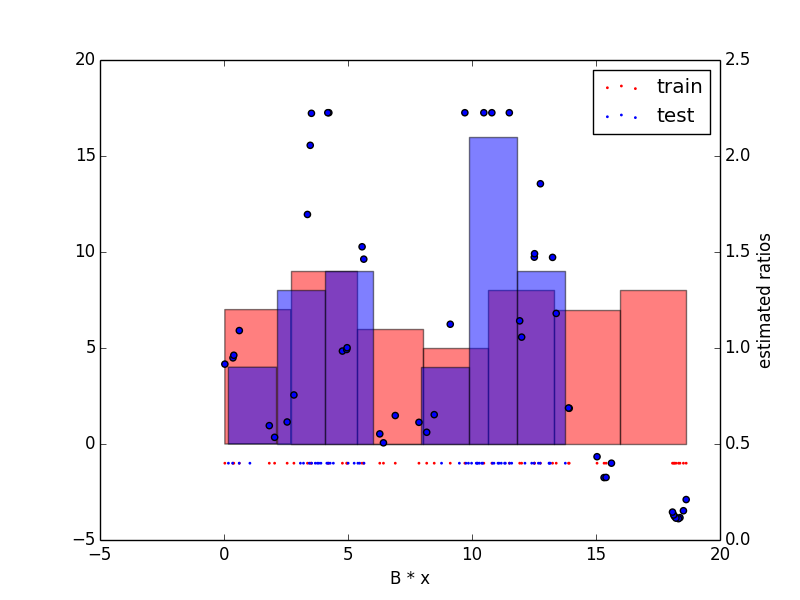

16.8587202708 error
99.8643228053 B norm


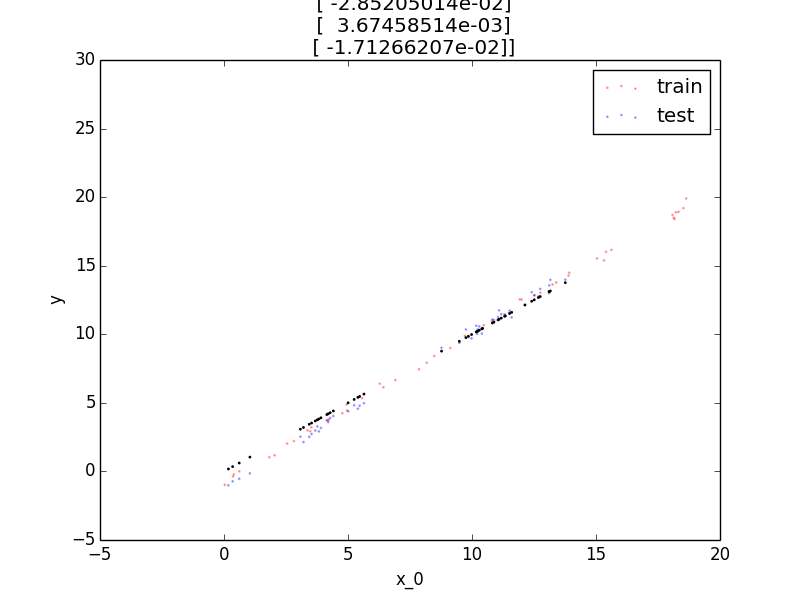

2.0 max pre
2.22539842988 max post
2.0 max pre
2.22539842988 max post
Autograd FloatNode with value 2.0 and 1 tape(s) max pre
Autograd FloatNode with value 2.22539842988 and 1 tape(s) max post
num_tight: 0
solver error: 8.48672575583e-05
2.0 max pre
2.22539842988 max post
Autograd FloatNode with value 2.0 and 1 tape(s) max pre
Autograd FloatNode with value 2.22539842988 and 1 tape(s) max post
2.0 max pre
2.22719199362 max post
2.0 max pre
2.22719273482 max post
2.0 max pre
2.22719273482 max post
Autograd FloatNode with value 2.0 and 1 tape(s) max pre
Autograd FloatNode with value 2.22719273482 and 1 tape(s) max post
num_tight: 0
solver error: 7.82854821039e-05
2.0 max pre
2.22719273482 max post
Autograd FloatNode with value 2.0 and 1 tape(s) max pre
Autograd FloatNode with value 2.22719273482 and 1 tape(s) max post
2.0 max pre
2.22719239205 max post
2.0 max pre
2.2271924586 max post
2.0 max pre
2.2271924586 max post
Autograd FloatNode with value 2.0 and 1 tape(s) max pre
Autograd Float

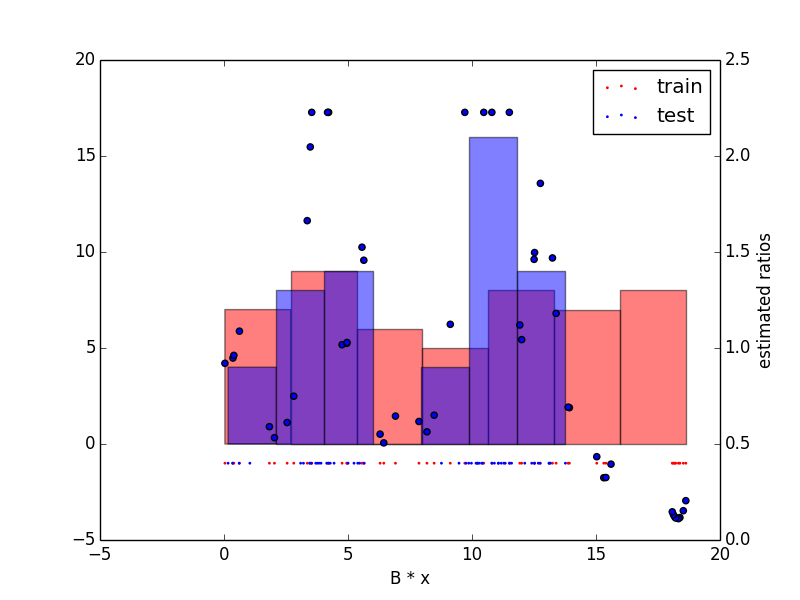

16.9537084926 error
99.8429059332 B norm


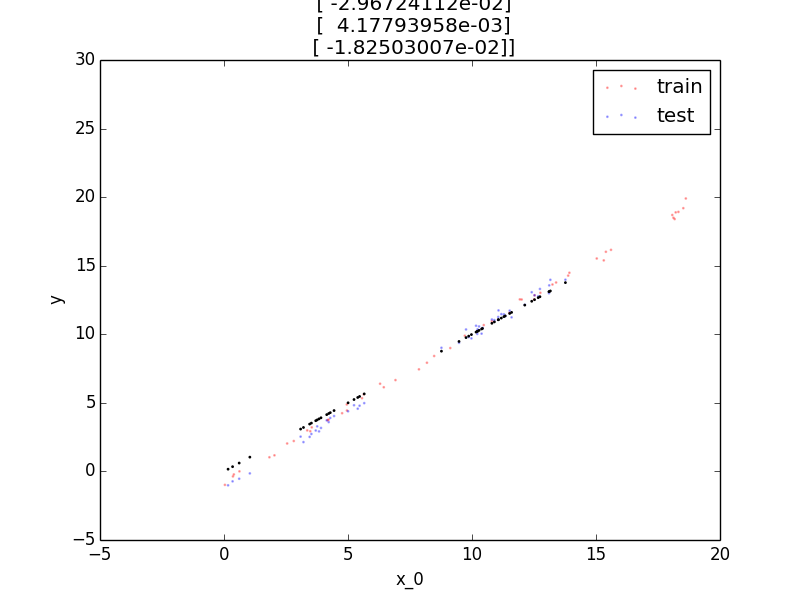

2.0 max pre
2.22736905974 max post
2.0 max pre
2.22736905974 max post
Autograd FloatNode with value 2.0 and 1 tape(s) max pre
Autograd FloatNode with value 2.22736905974 and 1 tape(s) max post
num_tight: 0
solver error: 7.88114365574e-05
2.0 max pre
2.22736905974 max post
Autograd FloatNode with value 2.0 and 1 tape(s) max pre
Autograd FloatNode with value 2.22736905974 and 1 tape(s) max post
2.0 max pre
2.2273105487 max post
2.0 max pre
2.22731029043 max post
2.0 max pre
2.22731029043 max post
Autograd FloatNode with value 2.0 and 1 tape(s) max pre
Autograd FloatNode with value 2.22731029043 and 1 tape(s) max post
num_tight: 0
solver error: 7.8397572319e-05
2.0 max pre
2.22731029043 max post
Autograd FloatNode with value 2.0 and 1 tape(s) max pre
Autograd FloatNode with value 2.22731029043 and 1 tape(s) max post
2.0 max pre
2.22731013774 max post
2.0 max pre
2.22730987494 max post
2.0 max pre
2.22730987494 max post
Autograd FloatNode with value 2.0 and 1 tape(s) max pre
Autograd Float

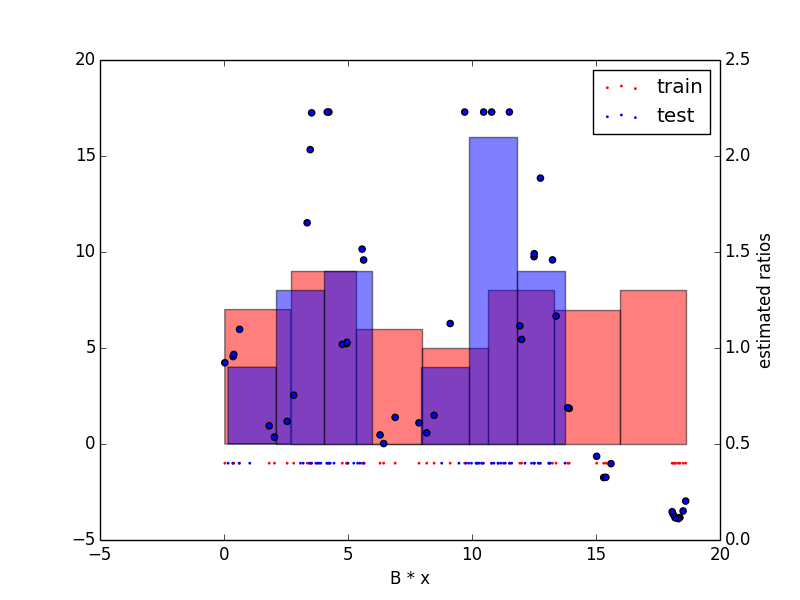

16.9425619402 error
99.7888258881 B norm


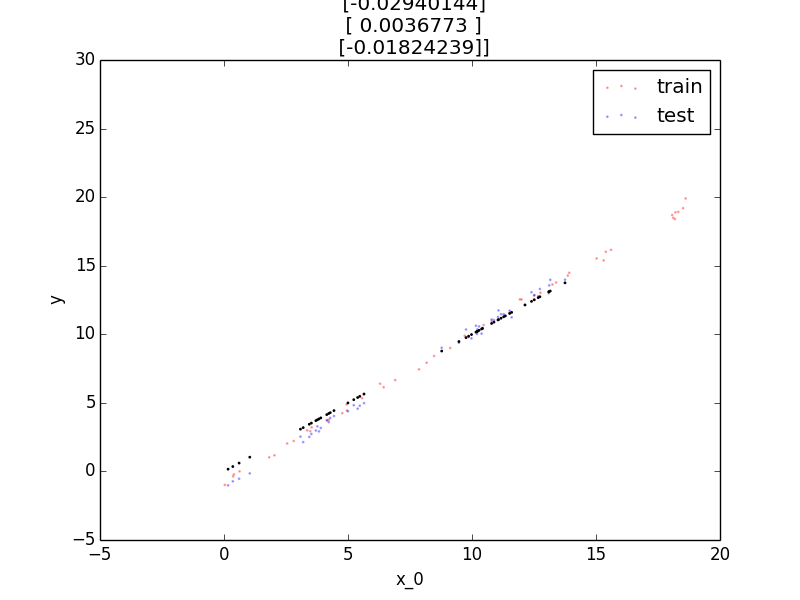

2.0 max pre
2.22898109726 max post
2.0 max pre
2.22898109726 max post
Autograd FloatNode with value 2.0 and 1 tape(s) max pre
Autograd FloatNode with value 2.22898109726 and 1 tape(s) max post
num_tight: 0
solver error: 7.76273963638e-05
2.0 max pre
2.22898109726 max post
Autograd FloatNode with value 2.0 and 1 tape(s) max pre
Autograd FloatNode with value 2.22898109726 and 1 tape(s) max post
2.0 max pre
2.24612303442 max post
2.0 max pre
2.24612260869 max post
2.0 max pre
2.24612260869 max post
Autograd FloatNode with value 2.0 and 1 tape(s) max pre
Autograd FloatNode with value 2.24612260869 and 1 tape(s) max post
num_tight: 0
solver error: 8.51921917363e-05
2.0 max pre
2.24612260869 max post
Autograd FloatNode with value 2.0 and 1 tape(s) max pre
Autograd FloatNode with value 2.24612260869 and 1 tape(s) max post
2.0 max pre
2.22918356826 max post
2.0 max pre
2.22918407142 max post
2.0 max pre
2.22918407142 max post
Autograd FloatNode with value 2.0 and 1 tape(s) max pre
Autograd Flo

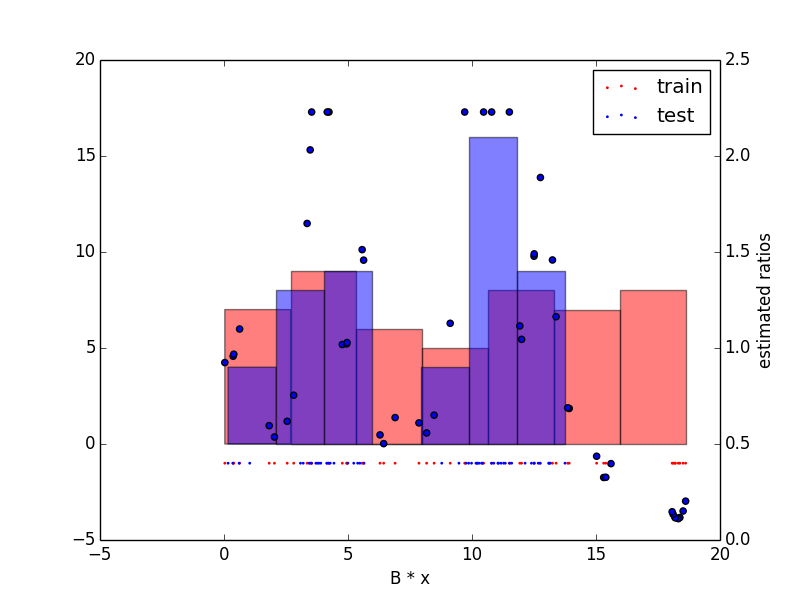

16.93485107 error
99.7802064058 B norm


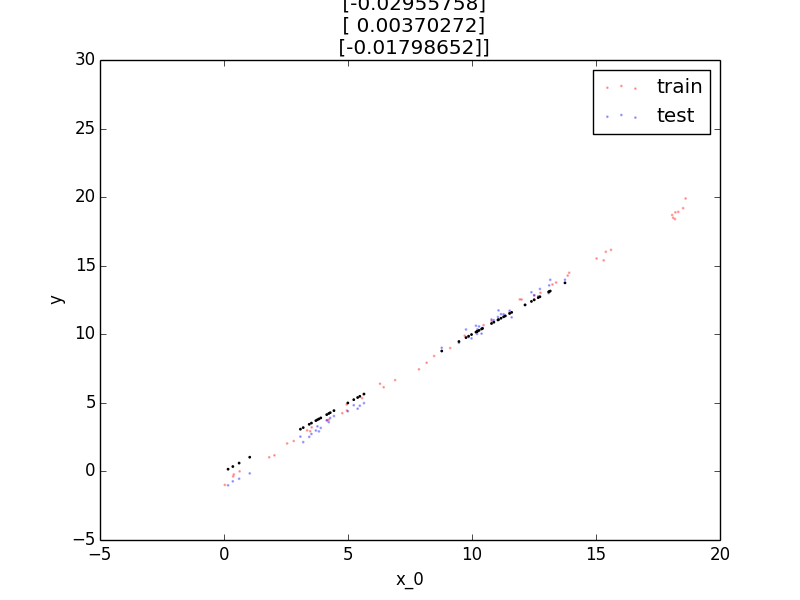

2.0 max pre
2.22907205189 max post
2.0 max pre
2.22907205189 max post
Autograd FloatNode with value 2.0 and 1 tape(s) max pre
Autograd FloatNode with value 2.22907205189 and 1 tape(s) max post
num_tight: 0
solver error: 7.71301132727e-05
2.0 max pre
2.22907205189 max post
Autograd FloatNode with value 2.0 and 1 tape(s) max pre
Autograd FloatNode with value 2.22907205189 and 1 tape(s) max post
2.0 max pre
2.2293273643 max post
2.0 max pre
2.22932889978 max post
2.0 max pre
2.22932889978 max post
Autograd FloatNode with value 2.0 and 1 tape(s) max pre
Autograd FloatNode with value 2.22932889978 and 1 tape(s) max post
num_tight: 0
solver error: 7.51644989629e-05
2.0 max pre
2.22932889978 max post
Autograd FloatNode with value 2.0 and 1 tape(s) max pre
Autograd FloatNode with value 2.22932889978 and 1 tape(s) max post
2.0 max pre
2.22909723964 max post
2.0 max pre
2.22909742492 max post
2.0 max pre
2.22909742492 max post
Autograd FloatNode with value 2.0 and 1 tape(s) max pre
Autograd Floa

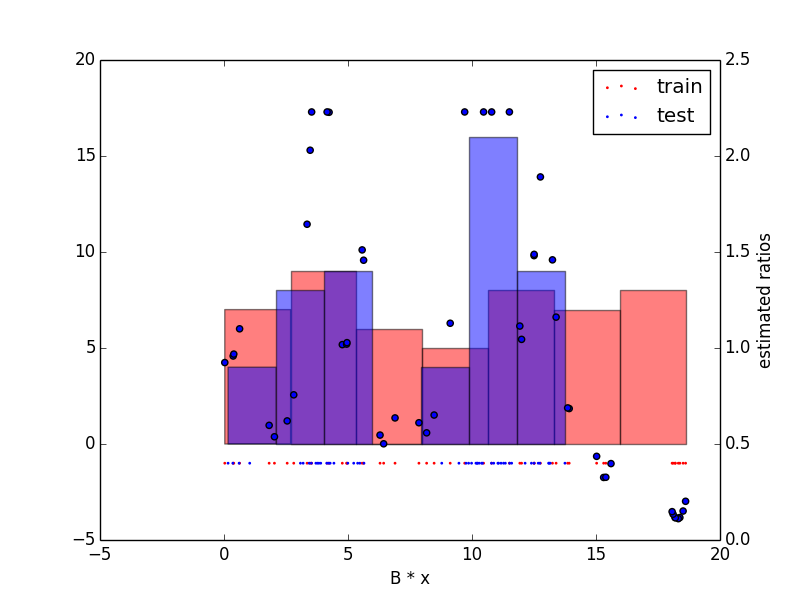

16.9230734833 error
99.7760668831 B norm


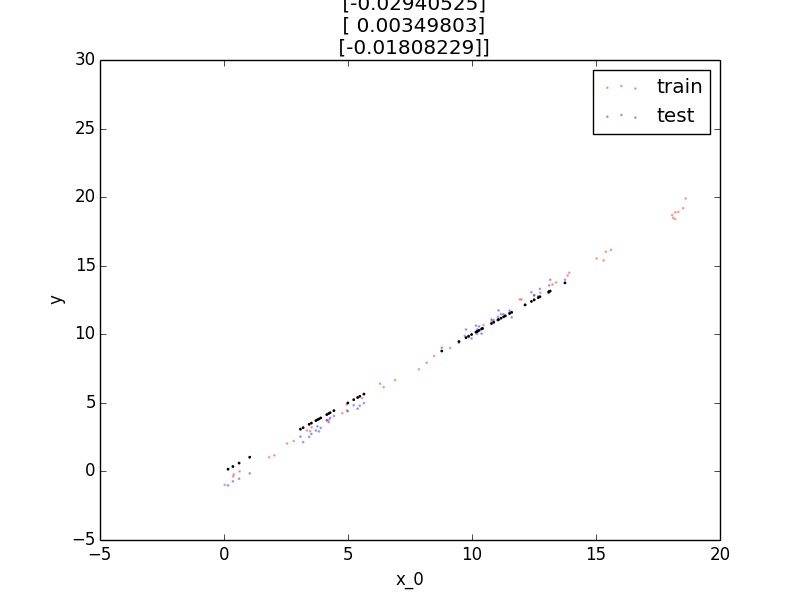

2.0 max pre
2.22938674657 max post
2.0 max pre
2.22938674657 max post
Autograd FloatNode with value 2.0 and 1 tape(s) max pre
Autograd FloatNode with value 2.22938674657 and 1 tape(s) max post
num_tight: 0
solver error: 7.73614407878e-05
2.0 max pre
2.22938674657 max post
Autograd FloatNode with value 2.0 and 1 tape(s) max pre
Autograd FloatNode with value 2.22938674657 and 1 tape(s) max post
2.0 max pre
2.2294199697 max post
2.0 max pre
2.22941927155 max post
2.0 max pre
2.22941927155 max post
Autograd FloatNode with value 2.0 and 1 tape(s) max pre
Autograd FloatNode with value 2.22941927155 and 1 tape(s) max post
num_tight: 0
solver error: 7.70187126851e-05
2.0 max pre
2.22941927155 max post
Autograd FloatNode with value 2.0 and 1 tape(s) max pre
Autograd FloatNode with value 2.22941927155 and 1 tape(s) max post
2.0 max pre
2.22942125569 max post
2.0 max pre
2.22942030067 max post
2.0 max pre
2.22942030067 max post
Autograd FloatNode with value 2.0 and 1 tape(s) max pre
Autograd Floa

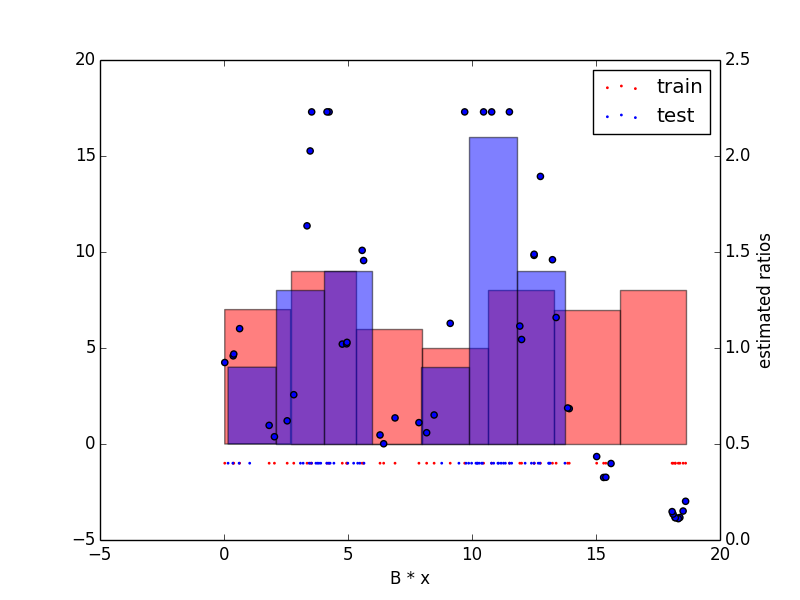

16.9328198954 error
99.78202506 B norm


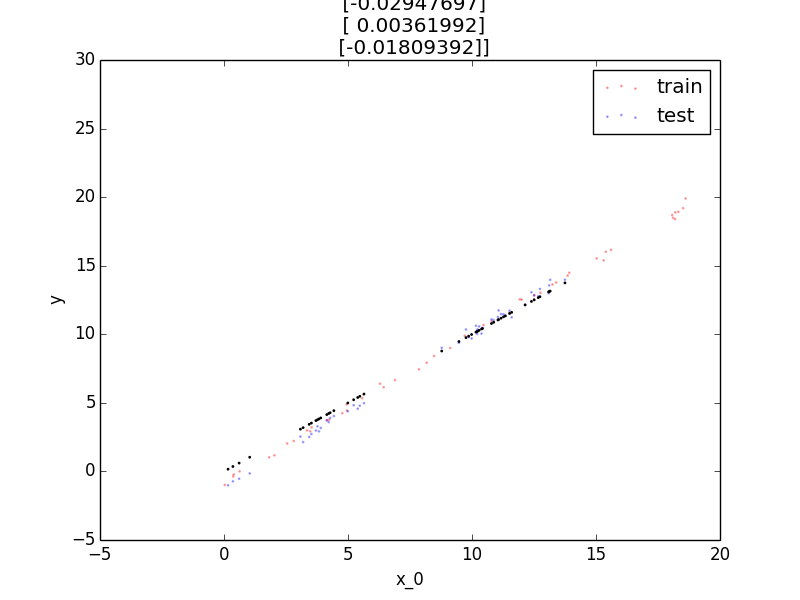

2.0 max pre
2.22968344301 max post
2.0 max pre
2.22968344301 max post
Autograd FloatNode with value 2.0 and 1 tape(s) max pre
Autograd FloatNode with value 2.22968344301 and 1 tape(s) max post
num_tight: 0
solver error: 7.79044091692e-05
2.0 max pre
2.22968344301 max post
Autograd FloatNode with value 2.0 and 1 tape(s) max pre
Autograd FloatNode with value 2.22968344301 and 1 tape(s) max post
2.0 max pre
2.2296837698 max post
2.0 max pre
2.22968380408 max post
2.0 max pre
2.22968380408 max post
Autograd FloatNode with value 2.0 and 1 tape(s) max pre
Autograd FloatNode with value 2.22968380408 and 1 tape(s) max post
num_tight: 0
solver error: 7.79036574098e-05
2.0 max pre
2.22968380408 max post
Autograd FloatNode with value 2.0 and 1 tape(s) max pre
Autograd FloatNode with value 2.22968380408 and 1 tape(s) max post
2.0 max pre
2.22968355215 max post
2.0 max pre
2.22968489696 max post
2.0 max pre
2.22968489696 max post
Autograd FloatNode with value 2.0 and 1 tape(s) max pre
Autograd Floa

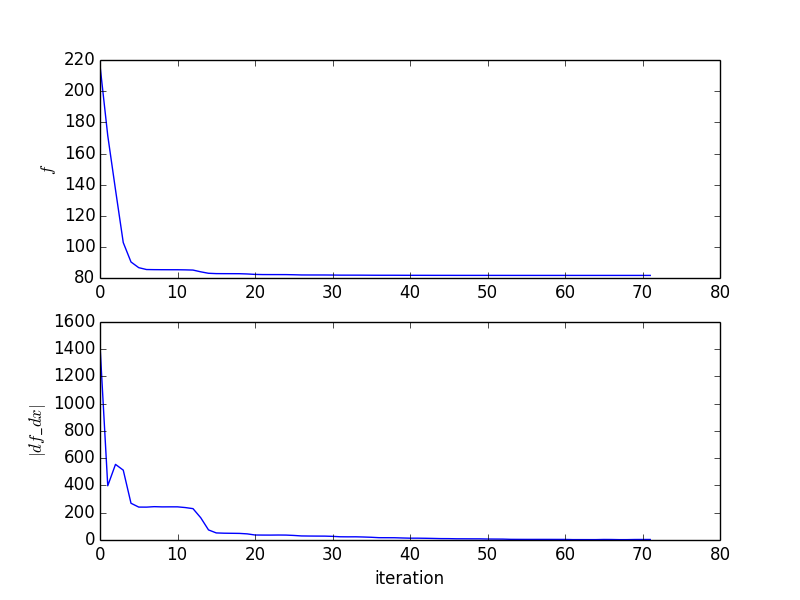

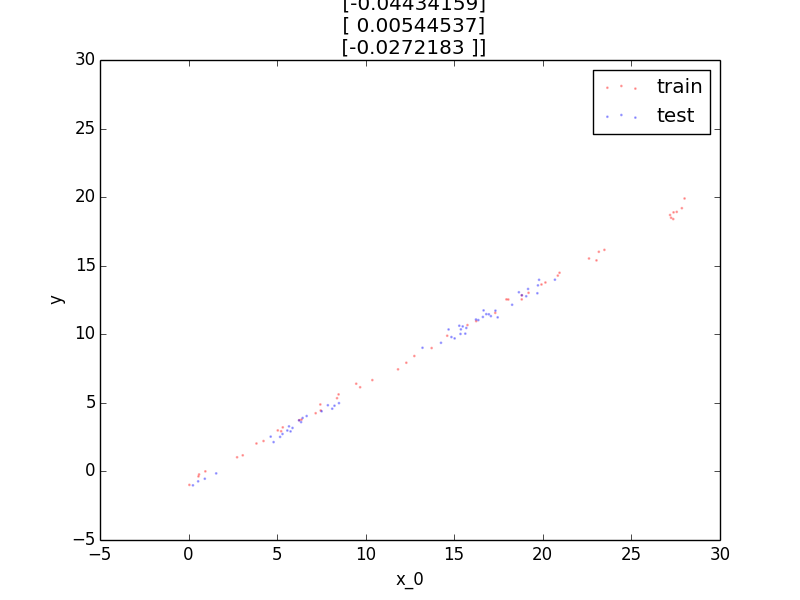

16.9328198954 test loss


In [15]:
# apply to higher dimensional data

np.random.seed(43)

# get data
#num_train, num_test = 100, 125
#num_train, num_test = 35, 50
#num_train, num_test = 125, 125
#num_train, num_test = 200, 200
#num_train, num_test = 600, 600
num_train, num_test = 50, 50
#x_dim = 500
#x_dim = 100
#x_dim = 30
x_dim = 50
#proportion = 0.1
proportion = 0.5
xs_train, xs_test, ys_train, ys_test = data.why_weighting_is_important_data(x_dim=x_dim, num_train=num_train, num_test=num_test, proportion=proportion)
#xs_train, xs_test, ys_train, ys_test = data.v_data(x_dim=x_dim, num_train=num_train, num_test=num_test)
data.data.plot_ys_v_xs(0, xs_train, xs_test, ys_train, ys_test)
data.data.plot_ys_v_xs(1, xs_train, xs_test, ys_train, ys_test)
data.data.plot_ys_v_xs(3, xs_train, xs_test, ys_train, ys_test)
fig, ax = plt.subplots()
asdf = np.zeros(x_dim)
asdf[0] = 1
data.data.plot_us(asdf, xs_train, xs_test, ax)
basic.display_fig_inline(fig)
print xs_train.shape, xs_test.shape, ys_train.shape, ys_test.shape
#assert False

#B_init_f = lambda: np.random.normal(size=(x_dim,))
B_init_f = lambda: np.array((1.,0)+(0,)*(x_dim-2))
#B_init_f = lambda: np.array([1.,0.])
B_init = B_init_f()

print np.max(np.dot(xs_train, B_init)), np.min(np.dot(xs_train, B_init))
#assert False

us_train_init, us_test_init = np.dot(xs_train, B_init).reshape((num_train,1)), np.dot(xs_test, B_init).reshape((num_test,1))
#sigma = np.array([utils.median_distance(np.concatenate((us_train_init, us_test_init)), np.concatenate((us_train_init, us_test_init)))])
sigma = np.array([0.25])
print sigma, 'sigma'
#pdb.set_trace()
#c_logreg = 11.1
c_logreg = 1.1
#c_logreg = 0.1
#c_B = 4.1
#c_B = 10.1
#c_B = 100.1
#c_B = 1.1
#c_B = 0.01
c_B = 150.1


# define optimizer
objective = lambda B: weighted_lsqr_loss_thru_ws_opt_fxn.val(ys_train, xs_train, xs_test, sigma, B, c_logreg, c_B)
dobjective_dB = lambda B: weighted_lsqr_loss_thru_ws_opt_fxn.grad(ys_train, xs_train, xs_test, sigma, B, c_logreg, c_B, care_argnums=(4,))

#weighted_lsqr_loss_thru_ws_opt_fxn.grad_check(ys_train, xs_train, xs_test, sigma, B, care_argnums=(4,))

#assert False
#print objective(B_init), 'objective'
#assert False

logreg_ratios_fxn = fxns.two_step( # xs_train, xs_test, sigma, B, c_logreg
    g=b_opt_given_B_fxn, # xs_train, xs_test, sigma, B, c_logreg
    h=fxns.fxn.autograd_fxn(_val=fxns.b_to_logreg_ratios_scale_sigma), # b_logreg, xs_train, xs_test, sigma, B
    g_argnums=(0,1,2,3,4),
    h_argnums=(0,1,2,3),
    g_val_h_argnum=0,
)
def info_f(B):
    ratios = logreg_ratios_fxn.val(xs_train, xs_test, sigma, B, c_logreg)

    fig, ax = plt.subplots()
    data.data.plot_us(B, xs_train, xs_test, ax)
    ratio_ax = ax.twinx()
    ratio_ax.scatter(np.dot(xs_train,B), ratios)
    ratio_ax.set_ylabel('estimated ratios')
    basic.display_fig_inline(fig)
    
    #b_opt = b_opt_given_B_fxn.val(xs_train, xs_test, sigma, B, c_logreg)
    ys_test_hat = np.dot(xs_test, B)
    error = ys_test - ys_test_hat
    #print np.dot(error, error), 'error'
    #pdb.set_trace()
    print np.dot(error,error), 'error'
    
    print np.linalg.norm(B) * c_B, 'B norm'
    fig, ax2 = plt.subplots()
    ax2.set_xlim(ax.get_xlim())
    B_normed = B / np.linalg.norm(B)
    data.data.plot_ys_v_xs(0, xs_train, xs_test, ys_train, ys_test, B=B, ax=ax2)
    #data.data.plot_ys_v_xs(0, xs_train, xs_test, ys_train, ys_test, B=B_normed, ax=ax2)
    ys_test_hat = np.dot(xs_test,B)
    #ax2.scatter(np.dot(xs_test,B_normed), ys_test_hat, marker='o', s=1.)
    ax2.scatter(np.dot(xs_test,B), ys_test_hat, marker='o', s=1.)
    basic.display_fig_inline(fig)
    #pdb.set_trace()

optimizer = optimizers.multiple_optimizer(optimizers.scipy_minimize_optimizer(verbose=5, info_f=info_f, options={'maxiter':161}), num_tries=1, num_args=1)
u_dim = 1
B_fit = optimizer.optimize(objective, dobjective_dB, B_init_f)
opt_log = optimizer.opt_log
optimizer.plot_objective(opt_log)
real_B_fit = utils.ortho(B_fit.reshape(B_fit.shape+(1,)))
data.data.plot_ys_v_xs(0, xs_train, xs_test, ys_train, ys_test, B=real_B_fit)

print fxns.weighted_squared_loss_given_B(B_fit, xs_test, ys_test, c=0), 'test loss'
#print fxns.weighted_squared_loss_given_B(b_fit, xs_test, ys_test, c=0.), 'test loss'

In [ ]:
# test gradient of full objective

# get data

np.random.seed(42)

num_train, num_test = 125, 125
xs_train, xs_test, ys_train, ys_test = data.why_weighting_is_important_data(x_dim=2, num_train=num_train, num_test=num_test)

sigma = np.array([2.25])
print 'sigma', sigma
#c_lsqr_loss, c_lsqr_loss_eval, c_B, c_logreg = 0.1, 0., 0.1, 0.1
c_lsqr_loss, c_lsqr_loss_eval, c_B, c_logreg = 1.1, 0., 0.1, 1.1

#B_init = np.random.normal(size=(2,))
#B_init_f = lambda: np.random.normal(size=(2,))
B_init_f = lambda: np.array([1.,0.])
B_init = B_init_f()

ws_full_train = np.random.uniform(size=num_train)

# create b_logreg to objective function
weighted_lsqr_loss_loss_fxn = fxns.two_step(# B, xs_train, ys_train, ws_train, c_lsqr_loss, c_lsqr_loss_eval
    g=fxns.fxn.autograd_fxn(_val=fxns.B_to_squared_losses), # B, xs_train, ys_train
    h=fxns.two_step( # B, xs_train, ls_train, ws_train, c_lsqr_loss, c_lsqr_loss_eval
        g=fxns.fxn.autograd_fxn(_val=fxns.weighted_lsqr_b_opt), # B, xs_train, ls_train, ws_train, c_lsqr_loss
        h=fxns.fxn.autograd_fxn(_val=fxns.weighted_squared_loss_given_b_opt), # B, xs_train, ls_train, ws_train, b_lsqr_loss, c_lsqr_loss_eval
        g_argnums=(0,1,2,3,4),
        h_argnums=(0,1,2,3,5),
        g_val_h_argnum=4,
    ),
    g_argnums=(0,1,2),
    h_argnums=(0,1,3,4,5),
    g_val_h_argnum=2
)

ws_train = np.random.uniform(size=num_train)
#weighted_lsqr_loss_loss_fxn.grad_check(B, xs_train, ys_train, ws_train, care_argnums=(0,))
#pdb.set_trace()
#print fxns.fxn.autograd_fxn(_val=fxns.weighted_lsqr_b_opt).val(B, xs_train, ys_train, ws_train)
#pdb.set_trace()
#fxns.fxn.autograd_fxn(_val=fxns.weighted_lsqr_b_opt).grad_check(B, xs_train, ys_train, ws_train, care_argnums=(0,))
#pdb.set_trace()
#ls_train = fxns.fxn.autograd_fxn(_val=fxns.B_to_squared_losses).val(B, xs_train, ys_train)
#print ls_train
#pdb.set_trace()
#fxns.two_step( # B, xs, ls, ws
#    g=fxns.fxn.autograd_fxn(_val=fxns.weighted_lsqr_b_opt), # B, xs, ys, ws
#    h=fxns.fxn.autograd_fxn(_val=fxns.weighted_squared_loss_given_b_opt), # B, xs, ys, ws, b_opt
#    g_argnums=(0,1,2,3),
#    h_argnums=(0,1,2,3),
#    g_val_h_argnum=4,
#).grad_check(B, xs_train, ls_train, ws_train, care_argnums=(0,))
#assert False
    
upper_bound_fxn = fxns.product( # B, xs_train, ys_train, ws_train, ws_full_train, c_lsqr_loss, c_lsqr_loss_eval
    g=fxns.fxn.autograd_fxn(_val=fxns.expected_conditional_PE_dist), # full_ws, ws
    h=weighted_lsqr_loss_loss_fxn, # B, xs_train, ys_train, ws_train, c_lsqr_loss, c_lsqr_loss_eval
    g_argnums=(4,3),
    h_argnums=(0,1,2,3,5,6)
)

tradeoff = 10.

objective_given_ws = fxns.sum(# B, xs_train, ys_train, ws_train, ws_full_train, c_lsqr_loss, c_lsqr_loss_eval, c_B
    fs=[
        fxns.fxn.autograd_fxn(_val=fxns.weighted_squared_loss_given_B), # B, xs, ys, c_B, ws
        upper_bound_fxn, # B, xs_train, ys_train, ws_train, ws_full_train, c_lsqr_loss, c_lsqr_loss_eval
        fxns.fxn.autograd_fxn(_val=fxns.weight_reg), # ws_train
       ],
    fs_argnums=[
        (0,1,2,7,3),
        (0,1,2,3,4,5,6),
        (3,)
    ],
    weights=[
        1.,
        1.,
        tradeoff,
    ],
)
    
objective_given_b_logreg = fxns.two_step(# b_logreg, xs_train, xs_test, ys_train, ws_full_train, sigma, B, c_lsqr_loss, c_lsqr_loss_eval, c_B
    g=fxns.fxn.autograd_fxn(_val=fxns.b_to_logreg_ratios_scale_sigma),# b_logreg, xs_train, xs_test, sigma, B
#    g=fxns.fxn.autograd_fxn(_val=fxns.b_to_logreg_ratios),# b_logreg, xs_train, xs_test, sigma, B
    h=objective_given_ws,# B, xs_train, ys_train, ws_train, ws_full_train, c_lsqr_loss, c_lsqr_loss_eval, c_B
    g_argnums=(0,1,2,5,6),
    h_argnums=(6,1,3,4,7,8,9),
    g_val_h_argnum=3,
)
    
# create final objective fxn
final_fxn = fxns.g_thru_f_opt(# ys_train, xs_train, xs_test, ws_full_train, sigma, B, c_lsqr_loss, c_lsqr_loss_eval, c_B, c_logreg
    g=b_opt_given_B_fxn,# xs_train, xs_test, sigma, B, c_logreg
    h=objective_given_b_logreg,# b_logreg, xs_train, xs_test, ys_train, ws_full_train, sigma, B, c_lsqr_loss, c_lsqr_loss_eval, c_B
    g_argnums=(1,2,4,5,9),
    h_argnums=(1,2,0,3,4,5,6,7,8),
    g_val_h_argnum=0
)
    
final_fxn.grad_check(ys_train, xs_train, xs_test, ws_full_train, sigma, B,  c_lsqr_loss, c_lsqr_loss_eval, c_B, c_logreg, care_argnums=(5,))